# Notebook to plot each wildfire as a separate case and compare pre-wildfire fits

This notebook shows Figure 3 and 7

In [1]:
import seaborn as sns

%matplotlib inline
sns.set(context='paper', font='Fira Sans Extra Condensed', style='ticks', palette='Accent', font_scale=1.2)
%config InlineBackend.figure_format = 'retina'

import matplotlib
matplotlib.font_manager._rebuild()

In [2]:
from geopandas import read_file, sjoin, overlay
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from numpy import mean
from pandas import timedelta_range, Timestamp, DatetimeIndex, date_range, read_csv, DataFrame
from numpy.random import choice
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib as mpl
import statsmodels.api as sm

In [3]:
df_1 = read_csv('data/processed/df_final_1.csv')
df_2 = read_csv('data/processed/df_final_2.csv')

In [4]:
df_1.head()

Unnamed: 0                     ID  time  values_ndvi  values_ndmi  \
0           1  CA3989212363920080621     1     0.667720     0.359276   
1           2  CA3989212363920080621     2     0.646469     0.290831   
2           3  CA3989212363920080621     3          NaN          NaN   
3           4  CA3989212363920080621     4          NaN          NaN   
4           5  CA3989212363920080621     5     0.653363     0.604286   

   values_nbr  values_nbr2  values_evi  values_sail  values_msavi  ...  \
0    0.620126     0.335626    1.890170     1.001381      0.800720  ...   
1    0.546790     0.304359    1.832495     0.969515      0.785239  ...   
2         NaN          NaN         NaN          NaN           NaN  ...   
3         NaN          NaN         NaN          NaN           NaN  ...   
4    0.818143     0.422971    5.140913     0.979859      0.790306  ...   

                 ID_FIRE       dates  exposure        bi        vs         pr  \
0  CA3989212363920080621  1990-01-07         0 -1.205130  2.640828  12.597606   
1  CA3989212363920080621  1990-01-21         0 -1.337318  2.414807   1.457818   
2  CA3989212363920080621  1990-02-04         0 -1.566425  2.465508   2.416603   
3  CA3989212363920080621  1990-02-18         0 -1.562331  2.302305   1.696652   
4  CA3989212363920080621  1990-03-04         0 -1.317977 -0.059309   0.546578   

       tmmx  stratified_group_by_probability  ID_new_numeric  \
0 -1.292586                                1             413   
1 -1.245352                                1             413   
2 -1.432461                                1             413   
3 -1.676061                                1             413   
4 -0.820947                                1             413   

                    ID_new  
0  CA3989212363920080621_A  
1  CA3989212363920080621_A  
2  CA3989212363920080621_A  
3  CA3989212363920080621_A  
4  CA3989212363920080621_A  

[5 rows x 29 columns]

In [5]:
dict_wf_strati = df_1.groupby(['ID_FIRE', 'stratified_group_by_probability']).first().reset_index()[['ID_FIRE', 'stratified_group_by_probability']].set_index('ID_FIRE').to_dict()['stratified_group_by_probability']

In [6]:
dict_treatments = dict()
for id_ in df_1.ID.unique():
    df_ = df_1[df_1.ID == id_].reset_index()
    dict_treatments[id_] = df_.sort_values('time')['treated'].ne(0).idxmax()

In [7]:
dict_treatments

{'CA3989212363920080621': 482,
 'CA4084612185219920820': 69,
 'CA3950412282120030903': 357,
 'CA4048812292220080621': 482,
 'CA4046112240819990926': 254,
 'CA4120212362120091007': 516,
 'CA4072312226319900808': 16,
 'CA4035812356120150806': 668,
 'CA4099512207820120818': 590,
 'CA4032512290520080621': 482,
 'CA4096712232419990823': 252,
 'CA3959912231720000505': 270,
 'CA4069812251020080622': 482,
 'CA3965812261019880826': 0,
 'CA3976112380020080623': 482,
 'CA4035712344220150731': 667,
 'CA4114112280520140802': 641,
 'CA4072112286319940712': 118,
 'CA4003612349819900923': 19,
 'CA4098212158120080621': 482,
 'CA3988312279019940827': 121,
 'CA4036812200519980802': 224,
 'CA4090212304019870830': 0,
 'CA4025912391820030930': 359,
 'CA4119812272519870831': 0,
 'CA4024312331620110923': 567,
 'CA4034212258719900809': 16,
 'CA3996312371720060924': 437,
 'CA3970812376820080621': 482,
 'CA4015912260019900830': 17,
 'CA4038712317320150730': 667,
 'CA4044412185520050826': 408,
 'CA408371230221987

In [8]:
gdf = read_file('data/interim/gdf_now_landcover.shp')
gdf_california = read_file('data/interim/gdf_california.shp')

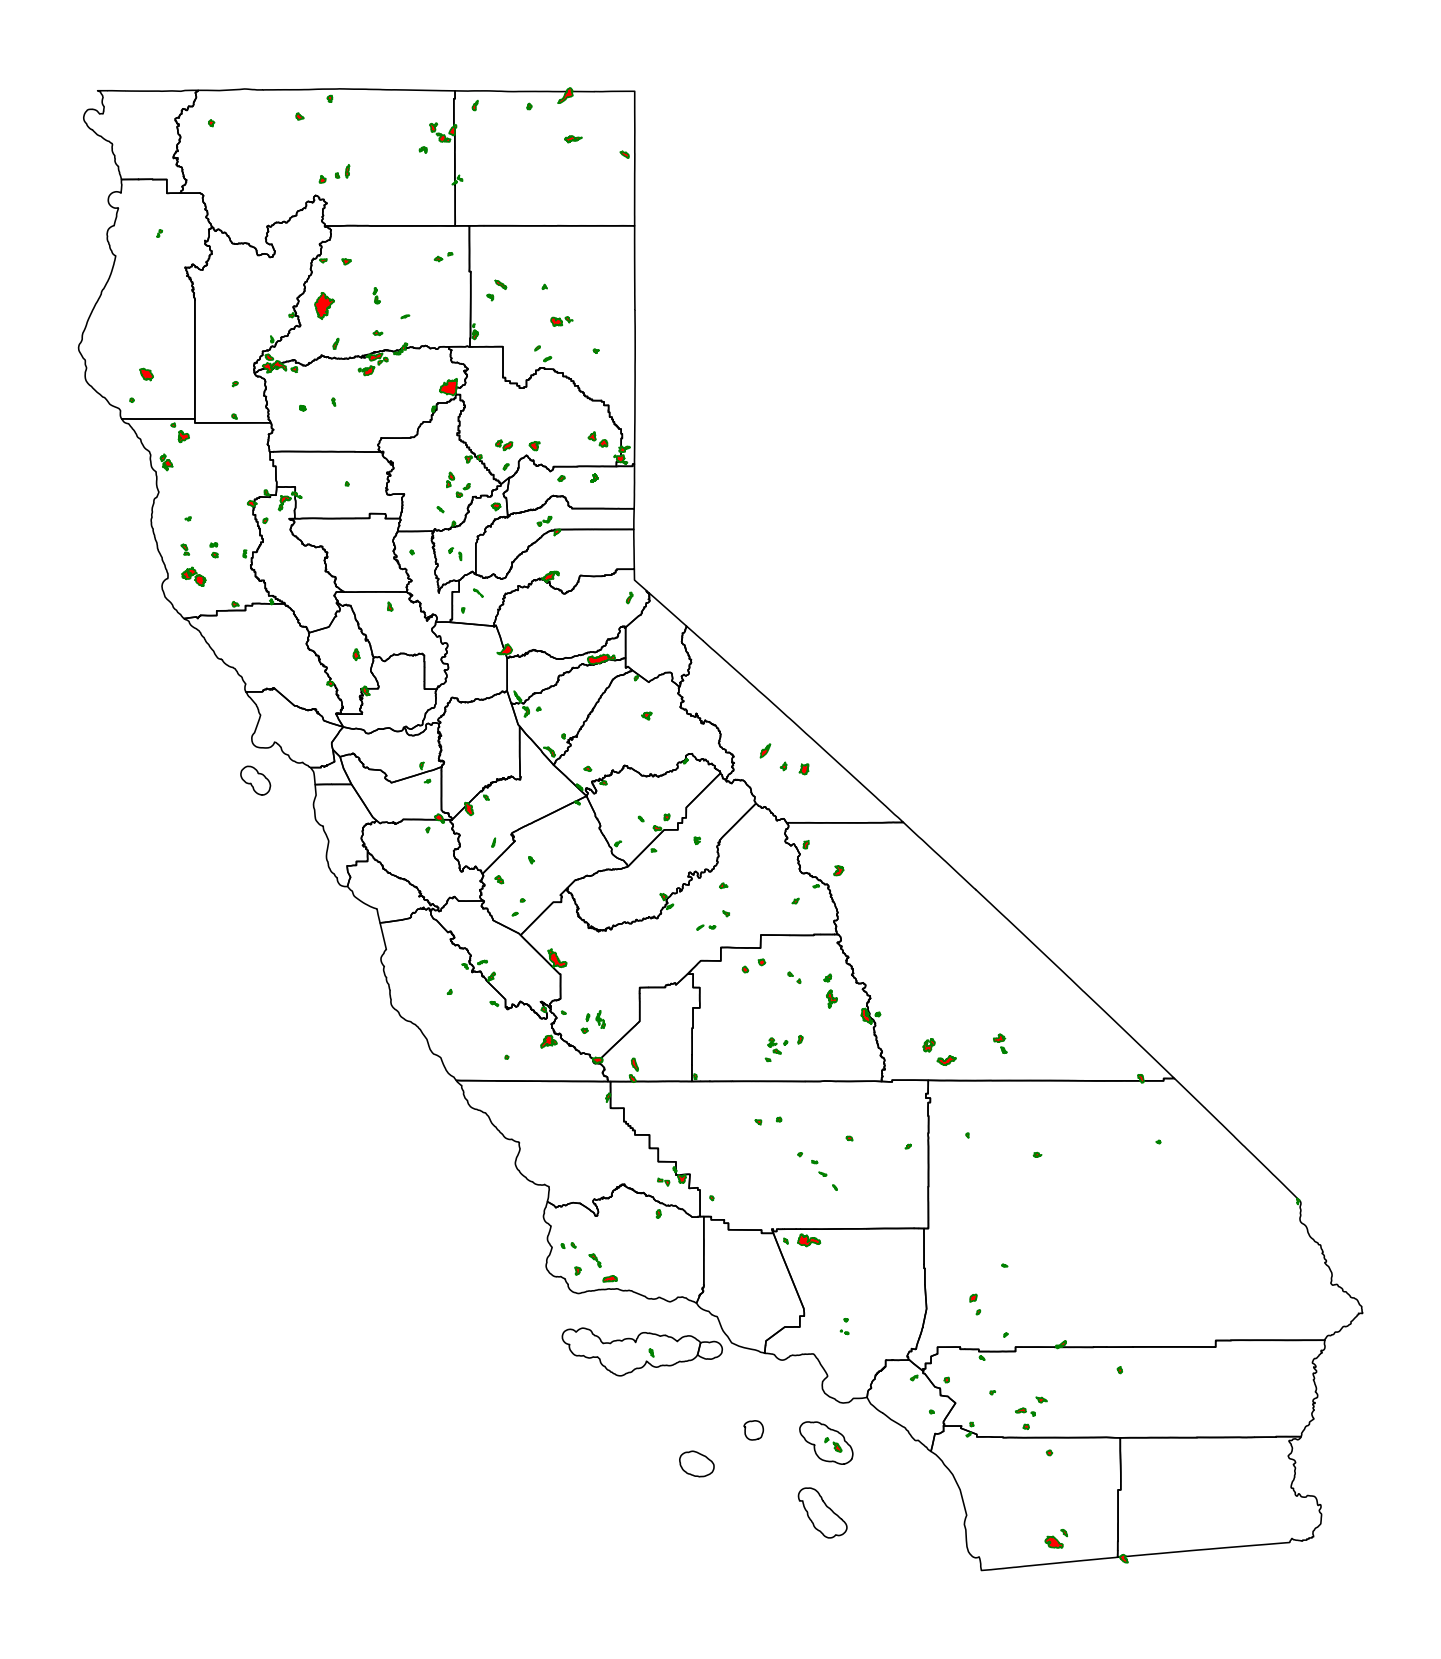

In [9]:
gdf_county = read_file('data/external/CA_Counties/CA_Counties_TIGER2016.shp')
list_north_cali_counties = ['Alameda','Alpine','Amador','Butte','Calaveras','Colusa',
                            'Contra Costa','Del Norte','El Dorado','Fresno','Glenn','Humboldt',
                            'Inyo','Kings','Lake','Lassen','Madera','Marin','Mariposa','Mendocino',
                            'Merced','Modoc','Mono','Monterey','Napa','Nevada','Placer','Plumas','Sacramento',
                            'San Benito','San Francisco','San Joaquin','San Mateo','Santa Clara','Santa Cruz',
                            'Shasta','Sierra','Siskiyou','Solano','Sonoma','Stanislaus','Sutter','Tehama','Trinity',
                            'Tulare','Tuolumne','Yolo','Yuba']
gdf_county['North_California'] = gdf_county.NAME.isin(list_north_cali_counties) * 1
fig, ax = plt.subplots(figsize=(15, 15))
gdf_county.plot(ax=ax, facecolor='none', edgecolor='k')
gdf[(gdf.Year < 2009) & (gdf.Year > 1995)].to_crs(gdf_county.crs).plot(ax=ax, facecolor='red', edgecolor='green')
plt.axis('off')
plt.show()


In [10]:


counties_to_zones_dict = {
    'San Bernardino': 6,
    'Riverside': 6,
    'San Diego': 6,
    'Imperial': 6,
    'Orange': 6,
    'Los Angeles':6,
    'Inyo':5,
    'Kern':5,
    'Kings':5,
    'Tulare':5,
    'Fresno':5,
    'Madera':5,
    'Mariposa':5,
    'Mono':5,
    'Tuolumne':5,
    'Calaveras':5,
    'Alpine':5,
    'Ventura':4,
    'Santa Barbara':4,
    'San Luis Obispo':4,
    'Monterey':4,
    'San Benito':4,
    'Santa Clara':4,
    'Santa Cruz':4,
    'San Mateo':4,
    'San Francisco':4,
    'Merced':3,
    'Stanislaus':3,
    'San Joaquin':3,
    'Alameda':3,
    'Contra Costa':3,
    'Sacramento':3,
    'Amador':3,
    'El Dorado':3,
    'Placer':3,
    'Yolo':2,
    'Sutter':2,
    'Yuba':2,
    'Nevada':2,
    'Sierra':2,
    'Clousa':2,
    'Glenn':2,
    'Butte':2,
    'Plumas':2,
    'Tehama':2,
    'Shasta':2,
    'Colusa':2,
    'Lassen':2,
    'Siskiyou':2,
    'Modoc':2,
    'Solano':1,
    'Marin':1,
    'Napa':1,
    'Sonoma':1,
    'Lake':1,
    'Mendocino':1,
    'Humboldt':1,
    'Trinity':1,
    'Del Norte':1
    
}

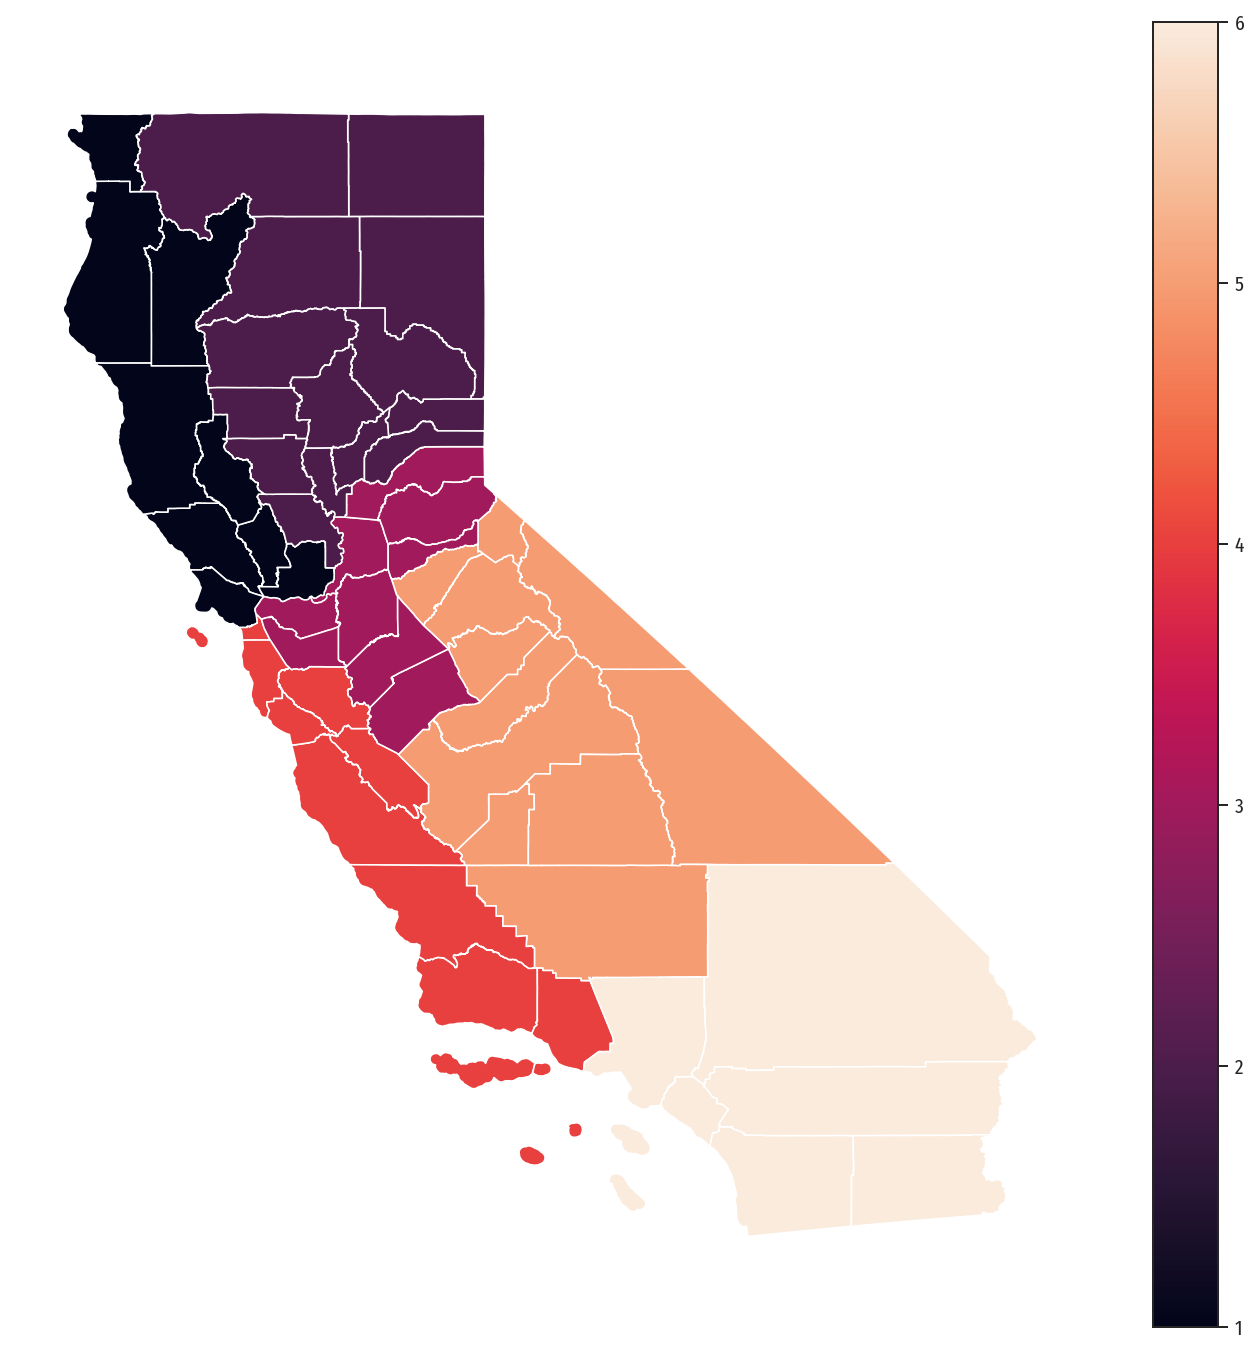

In [11]:
gdf_county['ZONE_MAP'] = gdf_county.NAME.apply(lambda x: counties_to_zones_dict[x])
gdf_county.plot('ZONE_MAP', figsize=(12, 12), legend=True)
plt.axis('off')
plt.show()

In [12]:
gdf_join_county_wildfires = sjoin(gdf_county, gdf.to_crs(gdf_county.crs))
gdf_join_county_wildfires = gdf_join_county_wildfires.reset_index()

In [13]:
gdf_overlay_county_wildfires = overlay(gdf_county, gdf.to_crs(gdf_county.crs))
gdf_overlay_county_wildfires.groupby('Fire_ID').count()['STATEFP'].value_counts()

1    475
2     66
3      2
Name: STATEFP, dtype: int64

In [14]:
gdf_join_county_wildfires['area_overlap'] = gdf_overlay_county_wildfires.geometry.area

In [15]:
gdf_join_county_wildfires.groupby(['Fire_ID', gdf_join_county_wildfires.index])['area_overlap'].max()

Fire_ID                   
CA3260811624320120517  72     6.459711e+05
CA3260911605720070605  554    6.451954e+06
CA3271011638520120617  73     6.062524e+06
CA3271711662220060723  74     9.585093e+07
CA3274911631019920719  75     6.259989e+06
                                  ...     
CA4193012339419870830  592    3.770204e+07
CA4195112245520040724  593    1.713368e+07
CA4196012323320120805  594    8.045034e+06
CA4197112054520070710  419    1.221135e+07
CA4199712363419870830  411    4.167726e+07
Name: area_overlap, Length: 613, dtype: float64

In [16]:
dict_zone_maps = dict(zip(gdf_join_county_wildfires.groupby(['Fire_ID', 'ZONE_MAP'])['area_overlap'].max().index.get_level_values(0).tolist(),
gdf_join_county_wildfires.groupby(['Fire_ID', 'ZONE_MAP'])['area_overlap'].max().index.get_level_values(1).tolist()))

# Using 5 year pre-wildfire

In [17]:
df_Y_tr = read_csv('results/synthetic_control_objects/out_mc_ndvi_5y_pt/out_mc_ndvi_Y_tr.csv', index_col=0)
df_Y_co = read_csv('results/synthetic_control_objects/out_mc_ndvi_5y_pt/out_mc_ndvi_Y_co.csv', index_col=0)
df_Y_ct = read_csv('results/synthetic_control_objects/out_mc_ndvi_5y_pt/out_mc_ndvi_Y_ct.csv', index_col=0)

In [18]:
365 / 14

26.071428571428573

In [19]:
gdf[gdf.Fire_Name.isin(['HORSE', 'THURMAN', 'SHIRLEY'])]

Fire_ID Fire_Name  Year  StartMonth  StartDay Fire_Type  \
3    CA3271711662220060723     HORSE  2006           7        23        WF   
47   CA3411611700820051005   THURMAN  2005          10         5        WF   
128  CA3571711855520140613   SHIRLEY  2014           6        13        WF   
537  CA4190612128619960810     HORSE  1996           8        10        WF   

       Acres State    landcover  entropy_la  \
3    16719.0    CA  shrub_scrub    0.357648   
47    1076.0    CA  shrub_scrub    0.648800   
128   2794.0    CA  shrub_scrub    0.376491   
537   2602.0    CA  shrub_scrub    0.695818   

                                              geometry  
3    POLYGON ((-116.69248 32.72597, -116.69232 32.7...  
47   POLYGON ((-117.02185 34.10226, -117.02254 34.1...  
128  POLYGON ((-118.51053 35.68715, -118.51108 35.6...  
537  POLYGON ((-121.30015 41.88580, -121.30076 41.8...

In [20]:
path_to_results = 'results/'

0.01189373016349694
0.028969145557338236
Wildfire HORSE, predominated by shrub_scrub landcover, on year 2006, burned 16719.0 acres
Wildfire THURMAN, predominated by shrub_scrub landcover, on year 2005, burned 1076.0 acres
Wildfire SHIRLEY, predominated by shrub_scrub landcover, on year 2014, burned 2794.0 acres


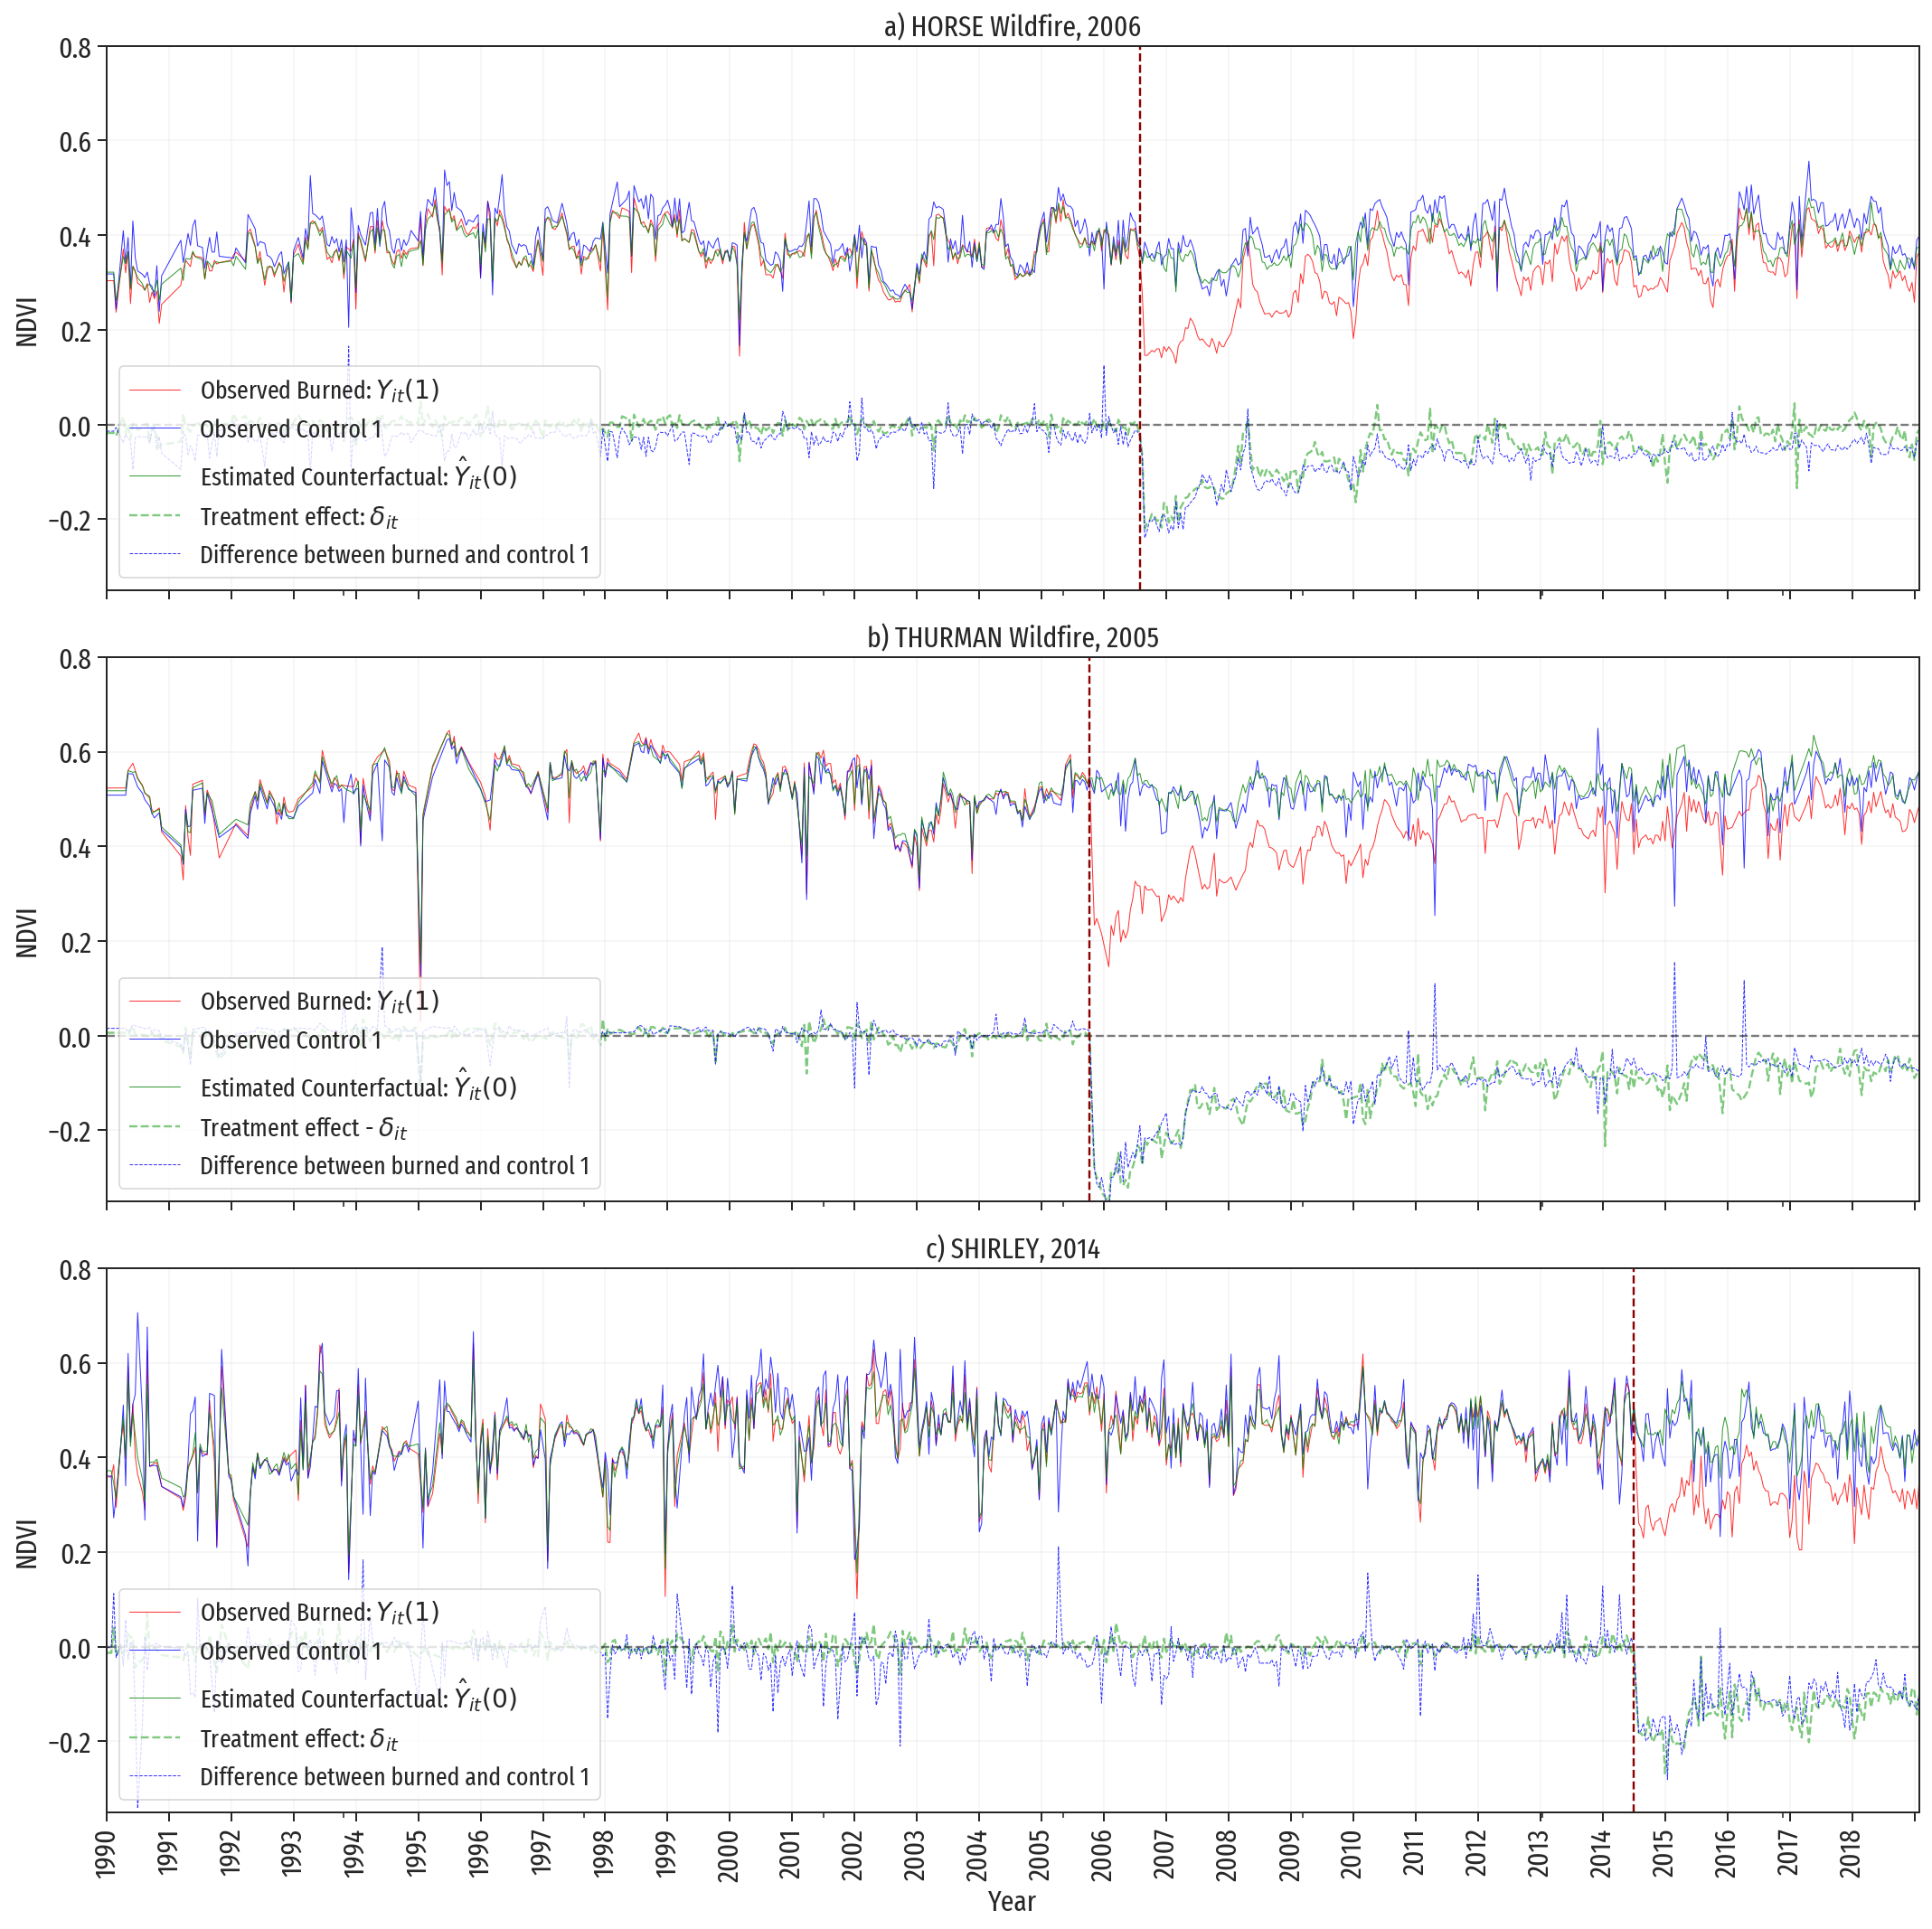

Wildfire SHIRLEY, predominated by shrub_scrub landcover, on year 2014, burned 2794.0 acres


In [21]:
id_ = 'CA3271711662220060723'
y_ = df_Y_tr['{}_A'.format(id_)].interpolate().fillna(method='ffill').fillna(method='bfill')
y_co_ = df_Y_co['{}_C1'.format(id_)].interpolate().fillna(method='ffill').fillna(method='bfill')
y_hat_ = df_Y_ct['{}_A'.format(id_)].interpolate().fillna(method='ffill').fillna(method='bfill')

print(mean_absolute_error(y_[:dict_treatments[id_]], y_hat_[:dict_treatments[id_]]))
print(mean_absolute_error(y_[:dict_treatments[id_]], y_co_[:dict_treatments[id_]]))
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(15, 15))

y_.plot(ax=ax[0], color='red', alpha=.8, linewidth=.5, label='Observed Burned: $Y_{it}(1)$')
y_co_.interpolate().plot(ax=ax[0], color='blue',alpha=.8, linewidth=.5, label='Observed Control 1')
y_hat_.interpolate().plot(ax=ax[0], color='green',alpha=.8, linewidth=.5, label='Estimated Counterfactual: $\hat{Y}_{it}(0)$')
title_ = gdf[gdf.Fire_ID == id_][['Fire_Name', 
                            'landcover', 
                            'Year',
                            'Acres']].values.tolist()[0]
print('Wildfire {}, predominated by {} landcover, on year {}, burned {} acres'.format(title_[0],
                                                                                             title_[1],
                                                                                             title_[2],
                                                                                             title_[3]))


(y_ - y_hat_).plot(ax=ax[0], label='Treatment effect: $\delta_{it}$', linestyle='--')
(y_ - y_co_).plot(ax=ax[0], color='blue',alpha=.8, linewidth=.5, linestyle='--', label='Difference between burned and control 1')
ax[0].axhline(y=0, xmin=0, xmax=757, color='k', linestyle='--', alpha=.5)
ax[0].legend(fontsize=14, loc='lower left')
ax[0].axvline(x=dict_treatments[id_], ymin=0, ymax=1, linestyle='--', color='darkred')
ax[0].set_xticks(ticks=list(range(1, 757, 26)))
ax[0].set_xticklabels(labels=[d.strftime('%Y') for d in date_range(start='1990-01-01', end='2019-12-01', freq='Y')],
           rotation=90)
ax[0].set_ylabel('NDVI')
ax[0].set_xlabel('Year')
ax[0].set_ylim([-.35, 0.8])
ax[0].set_xlim([1, 757])
ax[0].set_title('a) HORSE Wildfire, 2006')
ax[0].grid(True, alpha=.2)

id_ = 'CA3411611700820051005'
y_ = df_Y_tr['{}_A'.format(id_)].interpolate().fillna(method='ffill').fillna(method='bfill')
y_co_ = df_Y_co['{}_C1'.format(id_)].interpolate().fillna(method='ffill').fillna(method='bfill')
y_hat_ = df_Y_ct['{}_A'.format(id_)].interpolate().fillna(method='ffill').fillna(method='bfill')

y_.plot(ax=ax[1], color='red', alpha=.8, linewidth=.5, label='Observed Burned: $Y_{it}(1)$')
y_co_.interpolate().plot(ax=ax[1], color='blue',alpha=.8, linewidth=.5, label='Observed Control 1')
y_hat_.interpolate().plot(ax=ax[1], color='green',alpha=.8, linewidth=.5, label='Estimated Counterfactual: $\hat{Y}_{it}(0)$')
title_ = gdf[gdf.Fire_ID == id_][['Fire_Name', 
                            'landcover', 
                            'Year',
                            'Acres']].values.tolist()[0]

title_ = gdf[gdf.Fire_ID == id_][['Fire_Name', 
                            'landcover', 
                            'Year',
                            'Acres']].values.tolist()[0]
print('Wildfire {}, predominated by {} landcover, on year {}, burned {} acres'.format(title_[0],
                                                                                             title_[1],
                                                                                             title_[2],
                                                                                             title_[3]))
(y_ - y_hat_).plot(ax=ax[1], label='Treatment effect - $\delta_{it}$', linestyle='--')
(y_ - y_co_).plot(ax=ax[1], color='blue',alpha=.8, linewidth=.5, linestyle='--', label='Difference between burned and control 1')
ax[1].axhline(y=0, xmin=0, xmax=757, color='k', linestyle='--', alpha=.5)
ax[1].legend(fontsize=14, loc='lower left')
ax[1].axvline(x=dict_treatments[id_], ymin=0, ymax=1, linestyle='--', color='darkred')
ax[1].set_xticks(ticks=list(range(1, 757, 26)))
ax[1].set_xticklabels(labels=[d.strftime('%Y') for d in date_range(start='1990-01-01', end='2019-12-01', freq='Y')],
           rotation=90)
ax[1].set_ylabel('NDVI')
ax[1].set_xlabel('Year')
ax[1].set_ylim([-.35, 0.8])
ax[1].set_xlim([1, 757])
ax[1].set_title('b) THURMAN Wildfire, 2005')
ax[1].grid(True, alpha=.2)



id_ = 'CA3571711855520140613'
y_ = df_Y_tr['{}_A'.format(id_)].interpolate().fillna(method='ffill').fillna(method='bfill')
y_co_ = df_Y_co['{}_C1'.format(id_)].interpolate().fillna(method='ffill').fillna(method='bfill')
y_hat_ = df_Y_ct['{}_A'.format(id_)].interpolate().fillna(method='ffill').fillna(method='bfill')

y_.plot(ax=ax[2], color='red', alpha=.8, linewidth=.5, label='Observed Burned: $Y_{it}(1)$')
y_co_.interpolate().plot(ax=ax[2], color='blue',alpha=.8, linewidth=.5, label='Observed Control 1')
y_hat_.interpolate().plot(ax=ax[2], color='green',alpha=.8, linewidth=.5, label='Estimated Counterfactual: $\hat{Y}_{it}(0)$')
title_ = gdf[gdf.Fire_ID == id_][['Fire_Name', 
                            'landcover', 
                            'Year',
                            'Acres']].values.tolist()[0]
print('Wildfire {}, predominated by {} landcover, on year {}, burned {} acres'.format(title_[0],
                                                                                             title_[1],
                                                                                             title_[2],
                                                                                             title_[3]))


(y_ - y_hat_).plot(ax=ax[2], label='Treatment effect: $\delta_{it}$', linestyle='--')
(y_ - y_co_).plot(ax=ax[2], color='blue',alpha=.8, linewidth=.5, linestyle='--', label='Difference between burned and control 1')
ax[2].axhline(y=0, xmin=0, xmax=757, color='k', linestyle='--', alpha=.5)
ax[2].legend(fontsize=14, loc='lower left')
ax[2].axvline(x=dict_treatments[id_], ymin=0, ymax=1, linestyle='--', color='darkred')
ax[2].set_xticks(ticks=list(range(1, 757, 26)))
ax[2].set_xticklabels(labels=[d.strftime('%Y') for d in date_range(start='1990-01-01', end='2019-12-01', freq='Y')],
           rotation=90)
ax[2].set_ylabel('NDVI')
ax[2].set_xlabel('Year')
ax[2].set_ylim([-.35, 0.8])
ax[2].set_xlim([1, 757])
ax[2].set_title('c) SHIRLEY, 2014')
ax[2].grid(True, alpha=.2)

for _row in range(3):     
        for item in ([ax[_row].title, ax[_row].xaxis.label, ax[_row].yaxis.label] +
                     ax[_row].get_xticklabels() + ax[_row].get_yticklabels()):
            item.set_fontsize(16)
            
plt.tight_layout()
plt.show()
fig.savefig(path_to_results+'Sample_wildfire_effect_HORSE.png',
        dpi=400,
        format='png',
        pil_kwargs={'compression':'tiff_lzw'})
print('Wildfire {}, predominated by {} landcover, on year {}, burned {} acres'.format(title_[0],
                                                                                             title_[1],
                                                                                             title_[2],
                                                                                             title_[3]))

#### To plot any specific FIRE_ID change it here

In [22]:
id_ = 'CA3387911608820060707'

0.008523990505678024
0.02912288287238606


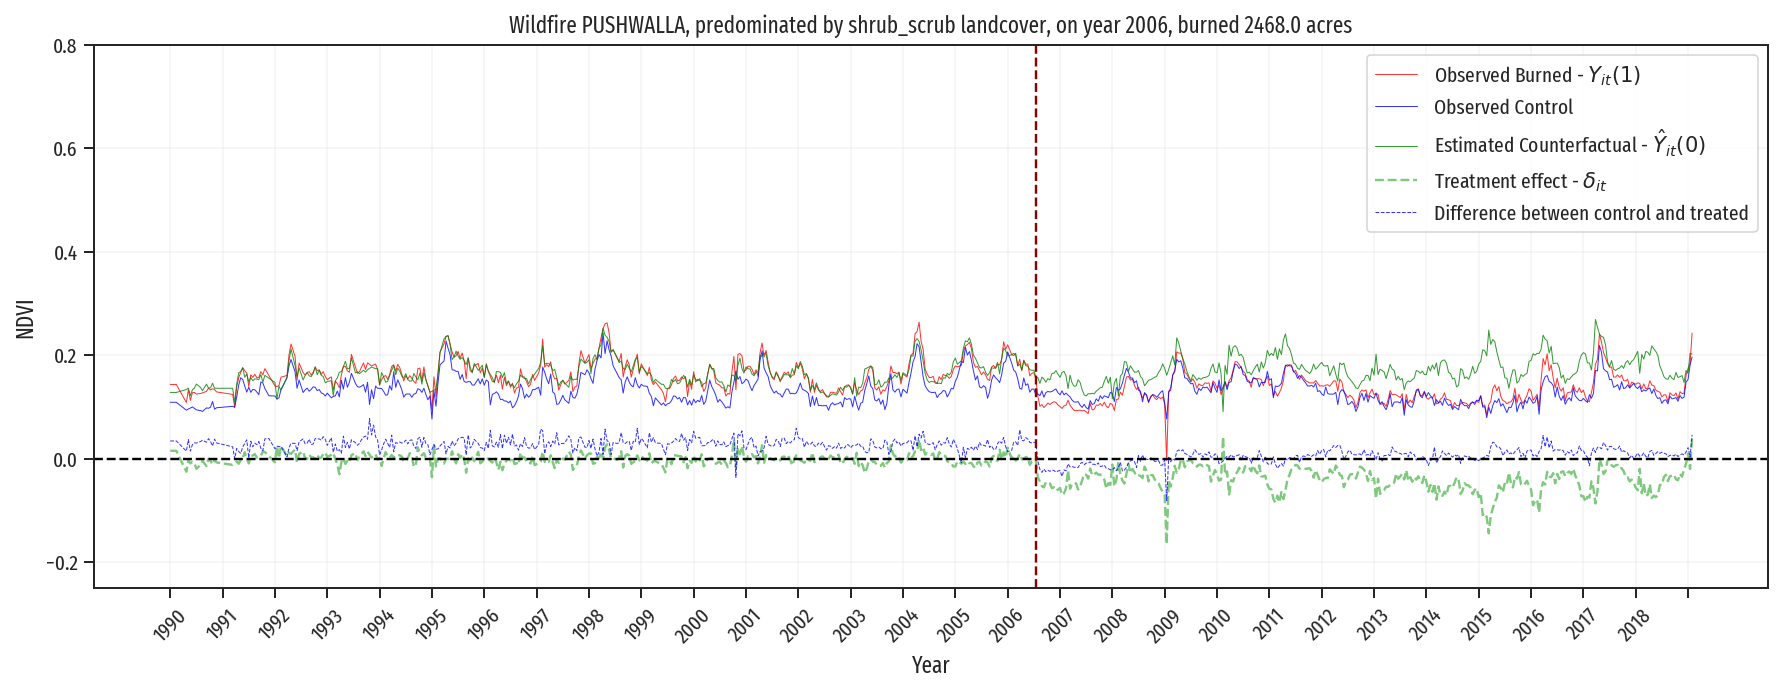

In [23]:
y_ = df_Y_tr['{}_A'.format(id_)].interpolate().fillna(method='ffill').fillna(method='bfill')
y_co_ = df_Y_co['{}_C1'.format(id_)].interpolate().fillna(method='ffill').fillna(method='bfill')
y_hat_ = df_Y_ct['{}_A'.format(id_)].interpolate().fillna(method='ffill').fillna(method='bfill')

print(mean_absolute_error(y_[:dict_treatments[id_]], y_hat_[:dict_treatments[id_]]))
print(mean_absolute_error(y_[:dict_treatments[id_]], y_co_[:dict_treatments[id_]]))
fig, ax = plt.subplots(figsize=(15, 5))

y_.plot(ax=ax, color='red', alpha=.8, linewidth=.5, label='Observed Burned - $Y_{it}(1)$')
y_co_.interpolate().plot(ax=ax, color='blue',alpha=.8, linewidth=.5, label='Observed Control')
y_hat_.interpolate().plot(ax=ax, color='green',alpha=.8, linewidth=.5, label='Estimated Counterfactual - $\hat{Y}_{it}(0)$')
title_ = gdf[gdf.Fire_ID == id_][['Fire_Name', 
                            'landcover', 
                            'Year',
                            'Acres']].values.tolist()[0]
plt.title('Wildfire {}, predominated by {} landcover, on year {}, burned {} acres'.format(title_[0],
                                                                                             title_[1],
                                                                                             title_[2],
                                                                                             title_[3]))
(y_ - y_hat_).plot(label='Treatment effect - $\delta_{it}$', linestyle='--')
(y_ - y_co_).plot(ax=ax, color='blue',alpha=.8, linewidth=.5, linestyle='--', label='Difference between control and treated')
plt.axhline(y=0, xmin=0, xmax=757, color='k', linestyle='--')
plt.legend()
plt.axvline(x=dict_treatments[id_], ymin=0, ymax=1, linestyle='--', color='darkred')
plt.xticks(ticks=list(range(1, 757, 26)), 
           labels=[d.strftime('%Y') for d in date_range(start='1990-01-01', end='2019-12-01', freq='Y')],
               rotation=45)
plt.ylabel('NDVI')
plt.xlabel('Year')
plt.ylim([-.25, 0.8])
#plt.xticks(list(range(len(date_range(start='1990-01-01', end='2019-12-01', freq='2W')))),
#           date_range(start='1990-01-01', end='2019-12-01', freq='Y'))
plt.grid(True, alpha=.2)
plt.show()

In [24]:
list_errors_yhat_pre = list()
list_errors_yco_pre = list()
list_ys_pre = list()
list_co_pre = list()
list_yhat_pre = list()
list_errors_yhat_post = list()
list_errors_yco_post = list()
list_errors_yhat_post_5 = list()
list_errors_yco_post_5 = list()
list_ids = list()
list_predominant_lc = list()
list_areas = list()
list_times_treatment = list()
list_zonemaps = list()
list_entropies = list()
list_years = list()
list_strati_groups = list()
list_fire_intensities = list()

make_plots = False
make_plots_2 = False
for id_ in df_Y_tr.columns.tolist():
    try:
        id_ = id_.split('_')[0]
        if make_plots:
            fig, ax = plt.subplots(figsize=(15, 5))

            df_Y_tr['{}_A'.format(id_)].interpolate().plot(ax=ax, color='red', alpha=.8, linewidth=.5, label='Observed Burned - $Y_{it}(1)$')
            df_Y_co['{}_C1'.format(id_)].interpolate().plot(ax=ax, color='blue',alpha=.8, linewidth=.5, label='Observed Control')
            df_Y_ct['{}_A'.format(id_)].interpolate().plot(ax=ax, color='green',alpha=.8, linewidth=.5, label='Estimated Counterfactual - $\hat{Y}_{it}(0)$')
            
        title_ = gdf[gdf.Fire_ID == id_][['Fire_Name', 
                                    'landcover', 
                                    'Year',
                                    'Acres', 'entropy_la']].values.tolist()[0]
        y_ = df_Y_tr['{}_A'.format(id_)].interpolate().fillna(0)
        y_co_ = df_Y_co['{}_C1'.format(id_)].interpolate().fillna(0)
        y_hat_ = df_Y_ct['{}_A'.format(id_)].interpolate().fillna(0)
        list_ys_pre.append(y_[:dict_treatments[id_]].fillna(0))
        list_co_pre.append(y_co_[:dict_treatments[id_]].fillna(0))
        list_yhat_pre.append(y_hat_[:dict_treatments[id_]].fillna(0))
        print(mean_absolute_error(y_[:dict_treatments[id_]], y_co_[:dict_treatments[id_]])/\
             mean_absolute_error(y_[:dict_treatments[id_]], y_hat_[:dict_treatments[id_]]))
        print('Counterfactuals ready.')
        list_ids.append(id_)
        list_predominant_lc.append(title_[1])
        list_areas.append(title_[3])
        list_errors_yhat_pre.append(mean_absolute_error(y_[:dict_treatments[id_]], y_hat_[:dict_treatments[id_]]))
        list_errors_yco_pre.append(mean_absolute_error(y_[:dict_treatments[id_]], y_co_[:dict_treatments[id_]]))
        list_errors_yhat_post.append(mean_absolute_error(y_[dict_treatments[id_]:], y_hat_[dict_treatments[id_]:]))
        list_errors_yco_post.append(mean_absolute_error(y_[dict_treatments[id_]:], y_co_[dict_treatments[id_]:]))
        list_errors_yhat_post_5.append(mean_absolute_error(y_[dict_treatments[id_]:dict_treatments[id_]+26*5], y_hat_[dict_treatments[id_]:dict_treatments[id_]+26*5]))
        list_errors_yco_post_5.append(mean_absolute_error(y_[dict_treatments[id_]:dict_treatments[id_]+26*5], y_co_[dict_treatments[id_]:dict_treatments[id_]+26*5]))
        list_times_treatment.append(dict_treatments[id_])
        list_zonemaps.append(dict_zone_maps[id_])
        list_entropies.append(title_[4])
        list_years.append(title_[2])
        list_strati_groups.append(dict_wf_strati[id_])
        print('All dta correctly stored in lists.')
        print('*' * 60)
        
        if make_plots_2:
            ((df_Y_tr['{}_A'.format(id_)].interpolate().rolling(window=6).mean() - \
             df_Y_ct['{}_A'.format(id_)].interpolate().rolling(window=6).mean()) \
             - (df_Y_tr['{}_A'.format(id_)].interpolate().rolling(window=6).mean() - \
                df_Y_co['{}_C1'.format(id_)].interpolate().rolling(window=6).mean())).plot(figsize=(15, 5))
            (df_Y_tr['{}_A'.format(id_)].interpolate().rolling(window=6).mean() - \
             df_Y_ct['{}_A'.format(id_)].interpolate().rolling(window=6).mean()).plot(color='r')
            (df_Y_tr['{}_A'.format(id_)].interpolate().rolling(window=6).mean() - \
                df_Y_co['{}_C1'.format(id_)].interpolate().rolling(window=6).mean()).plot(color='g')
            plt.vlines(x=dict_treatments[id_], ymin=-0.1, ymax=.1, linestyle='--', color='darkred')
            plt.title('Difference n.c. - s.c.')
            plt.show()
            
        if make_plots:
            print('+' * 60)
            print(id_)
            plt.title('Wildfire {}, predominated by {} landcover, on year {}, burned {} acres'.format(title_[0],
                                                                                                         title_[1],
                                                                                                         title_[2],
                                                                                                         title_[3]))
            (df_Y_tr['{}_A'.format(id_)].interpolate() - df_Y_ct['{}_A'.format(id_)].interpolate()).plot(label='Treatment effect - $\delta_{it}$', linestyle='--')
            (df_Y_tr['{}_A'.format(id_)].interpolate() - \
                df_Y_co['{}_C1'.format(id_)].interpolate()).plot(ax=ax, color='blue',alpha=.8, linewidth=.5, linestyle='--', label='Difference between control and treated')
            plt.axhline(y=0, xmin=0, xmax=757, color='k', linestyle='--')
            plt.legend()
            plt.axvline(x=dict_treatments[id_], ymin=0, ymax=1, linestyle='--', color='darkred')
            plt.xticks(ticks=list(range(1, 757, 26)), 
                       labels=[d.strftime('%Y') for d in date_range(start='1990-01-01', end='2019-12-01', freq='Y')],
                           rotation=45)
            plt.ylabel('NDVI')
            plt.xlabel('Year')
            plt.grid(True, alpha=.2)
            plt.show()
            
    except:
        print('ID:', id_, 'NOT FOUND.')
        

3.018908417590523
Counterfactuals ready.
All dta correctly stored in lists.
************************************************************
1.3549143201888147
Counterfactuals ready.
All dta correctly stored in lists.
************************************************************
2.098296467331061
Counterfactuals ready.
All dta correctly stored in lists.
************************************************************
2.4530972035106777
Counterfactuals ready.
All dta correctly stored in lists.
************************************************************
1.3605210475379108
Counterfactuals ready.
All dta correctly stored in lists.
************************************************************
2.507672555059278
Counterfactuals ready.
All dta correctly stored in lists.
************************************************************
1.5724468675132206
Counterfactuals ready.
All dta correctly stored in lists.
************************************************************
1.6374227031246442
Counterfactuals re

1.9774519344653185
Counterfactuals ready.
All dta correctly stored in lists.
************************************************************
1.8150883830176652
Counterfactuals ready.
All dta correctly stored in lists.
************************************************************
1.3571819209293843
Counterfactuals ready.
All dta correctly stored in lists.
************************************************************
0.9262507582301489
Counterfactuals ready.
All dta correctly stored in lists.
************************************************************
4.475139830635317
Counterfactuals ready.
All dta correctly stored in lists.
************************************************************
1.812934077096202
Counterfactuals ready.
All dta correctly stored in lists.
************************************************************
1.4222775739831663
Counterfactuals ready.
All dta correctly stored in lists.
************************************************************
1.2865736158556942
Counterfactuals r

All dta correctly stored in lists.
************************************************************
2.072294879148002
Counterfactuals ready.
All dta correctly stored in lists.
************************************************************
1.2678656333338738
Counterfactuals ready.
All dta correctly stored in lists.
************************************************************
2.051803549032201
Counterfactuals ready.
All dta correctly stored in lists.
************************************************************
1.6727428309524184
Counterfactuals ready.
All dta correctly stored in lists.
************************************************************
1.6413310529998892
Counterfactuals ready.
All dta correctly stored in lists.
************************************************************
2.3071399214695756
Counterfactuals ready.
All dta correctly stored in lists.
************************************************************
1.1521576242158003
Counterfactuals ready.
All dta correctly stored in lists.
*

3.310075687884796
Counterfactuals ready.
All dta correctly stored in lists.
************************************************************
2.1365951542559025
Counterfactuals ready.
All dta correctly stored in lists.
************************************************************
4.0498584980324015
Counterfactuals ready.
All dta correctly stored in lists.
************************************************************
6.223934049175558
Counterfactuals ready.
All dta correctly stored in lists.
************************************************************
1.4560270493522829
Counterfactuals ready.
All dta correctly stored in lists.
************************************************************
1.5933599549438933
Counterfactuals ready.
All dta correctly stored in lists.
************************************************************
3.61381291559393
Counterfactuals ready.
All dta correctly stored in lists.
************************************************************
3.324562300992131
Counterfactuals read

2.230587098132134
Counterfactuals ready.
All dta correctly stored in lists.
************************************************************
2.436002788129006
Counterfactuals ready.
All dta correctly stored in lists.
************************************************************
2.9161125633199463
Counterfactuals ready.
All dta correctly stored in lists.
************************************************************
1.827173432225458
Counterfactuals ready.
All dta correctly stored in lists.
************************************************************
4.588700392553633
Counterfactuals ready.
All dta correctly stored in lists.
************************************************************
1.0925352154250514
Counterfactuals ready.
All dta correctly stored in lists.
************************************************************
1.2801868904205027
Counterfactuals ready.
All dta correctly stored in lists.
************************************************************
2.4431784092457662
Counterfactuals rea

In [25]:
df_list_errors = DataFrame([list_errors_yhat_pre, list_errors_yco_pre,
                            list_errors_yhat_post, list_errors_yco_post,
                            list_errors_yhat_post_5, list_errors_yco_post_5,
                            list_ids, list_predominant_lc, list_areas, list_times_treatment,
                            list_zonemaps, list_entropies, list_years, list_strati_groups, 
                            list_fire_intensities]).T

In [26]:
df_list_errors.shape

(304, 15)

In [27]:
dict_lc_types = {'shrub_scrub':'Shrub/scrub',
                 'grassland_herbaceous':'Grassland - Herbaceous',
                 'evergreen_forest': 'Evergreen Forest',
                 'woody_wetlands': 'Woody - Wetlands',
                 'emergent_herbaceous_wetland': 'Emergent Herbaceous Weltand',
                 'cultivated_crops':'Cultivated Crops',
                 'rock_sand_clay':'Rock/Sand/Clay',
                 'developed_medium_intensity':'Developed Medium Intensity',
                 'mixed_forest':'Mixed Forest',
                 'developed_open_space':'Developed Open'}

In [28]:
df_list_errors.columns = ['error_yhat_pre', 'error_yco_pre',
                          'error_yhat_post', 'error_yco_post',
                          'error_yhat_post_5', 'error_yco_post_5',
                          'ID', 'LC', 'Area (acres)', 'time_treatment', 
                          'zone_map', 'entropy_lc', 'year', 'strati_group',
                          'fire_intensity']

In [29]:
df_list_errors['Most predominant Land Cover'] = df_list_errors['LC'].apply(lambda x: dict_lc_types[x])
df_list_errors['error_ratio'] = df_list_errors[['error_yhat_pre', 'error_yco_pre']].apply(lambda x: x[0] / x[1], axis=1)
df_list_errors.error_yhat_post_5 = df_list_errors.error_yhat_post_5.astype(float)

In [30]:
df_list_errors.dtypes

error_yhat_pre                  object
error_yco_pre                   object
error_yhat_post                 object
error_yco_post                  object
error_yhat_post_5              float64
error_yco_post_5                object
ID                              object
LC                              object
Area (acres)                    object
time_treatment                  object
zone_map                        object
entropy_lc                      object
year                            object
strati_group                    object
fire_intensity                  object
Most predominant Land Cover     object
error_ratio                    float64
dtype: object

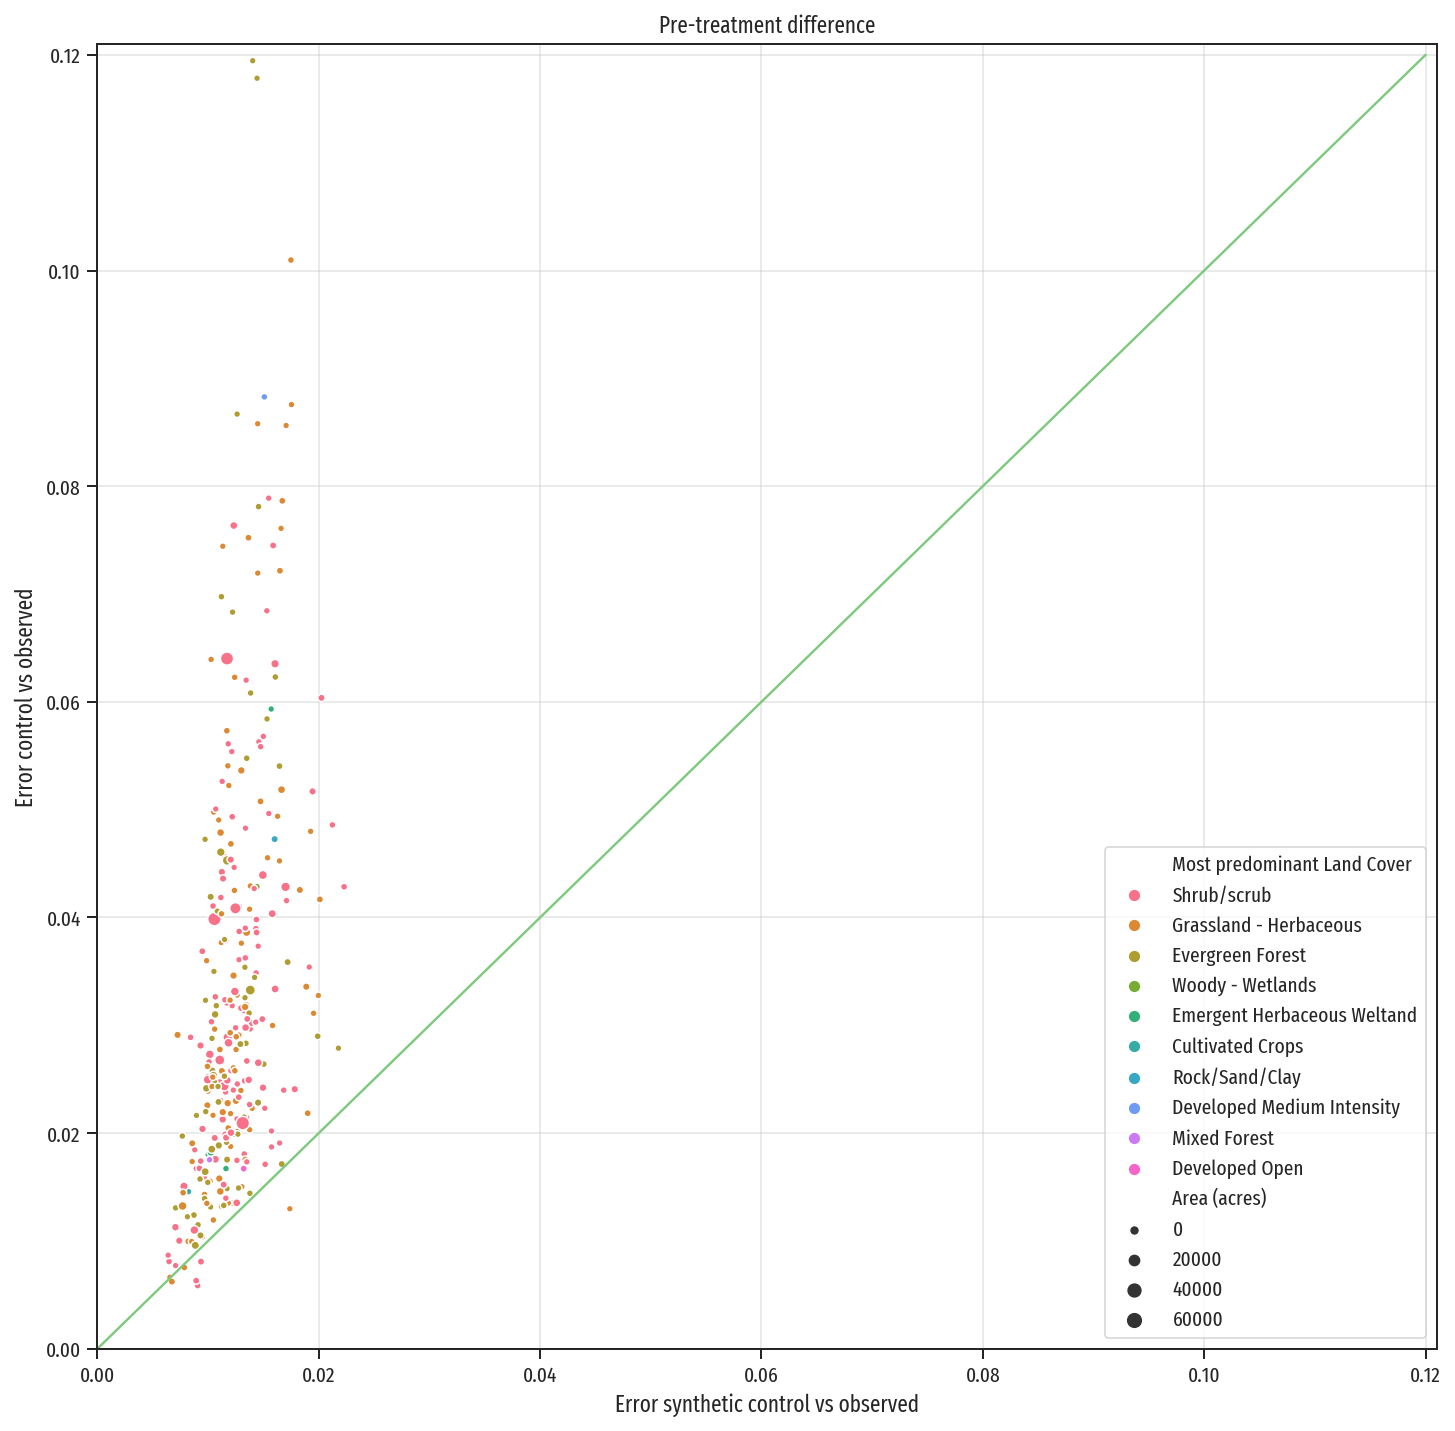

In [31]:
from pandas import to_numeric
path_to_results = 'results/'

df_list_errors["error_yhat_post_5"] = to_numeric(df_list_errors["error_yhat_post_5"])

fig = plt.figure(figsize=(12, 12))
sns.scatterplot('error_yhat_pre', 'error_yco_pre', 
                hue='Most predominant Land Cover',
                size='Area (acres)', data=df_list_errors)
plt.plot([0,.12], [0,.12])
plt.xlim([0,.121])
plt.ylim([0,.121])
plt.grid(True, alpha=.5)
plt.ylabel('Error control vs observed')
plt.xlabel('Error synthetic control vs observed')
plt.title('Pre-treatment difference')
plt.show()
fig.savefig(path_to_results+'Pretreatment_5yr_difference_counterfactual_observed.png',
        dpi=400,
        format='png',
        pil_kwargs={'compression':'tiff_lzw'})

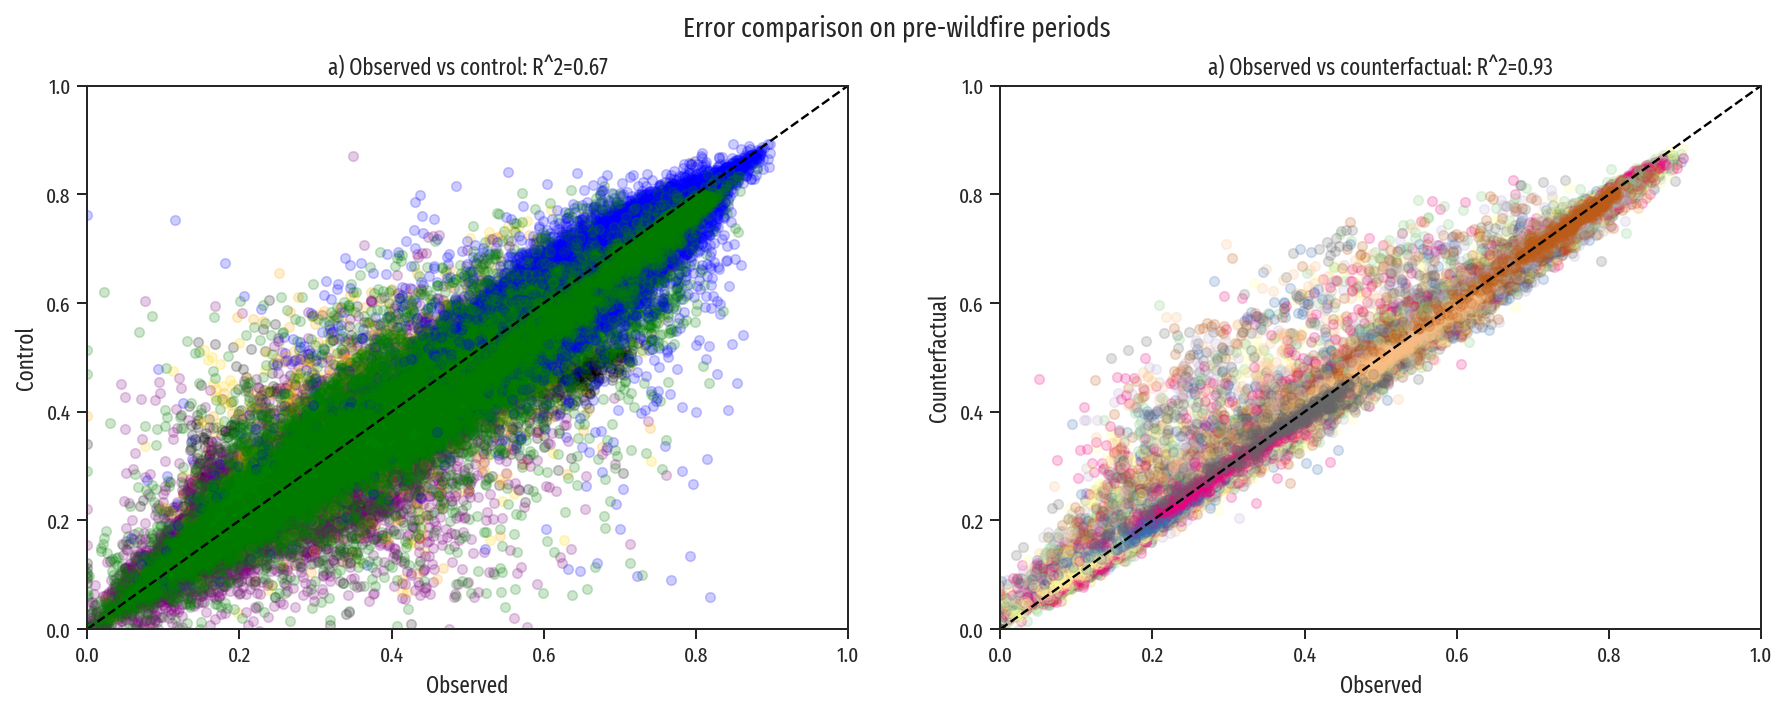

In [32]:
list_colors = ['red', 'blue', 'green', 'orange', 'gold', 'purple', 'black']
list_r2s_control = list()
list_r2s_counterfactual = list()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
for i in range(len(list_ys_pre)):
    ax[0].scatter(list_ys_pre[i], list_co_pre[i], alpha=.2, color=list_colors[list_zonemaps[i]])
    list_r2s_control.append(r2_score(list_ys_pre[i], list_co_pre[i]))
    ax[1].scatter(list_ys_pre[i], list_yhat_pre[i], alpha=.2, cmap=list_colors[list_zonemaps[i]])
    list_r2s_counterfactual.append(r2_score(list_ys_pre[i], list_yhat_pre[i]))
ax[0].plot([0, 1], [0, 1], color='k', linestyle='--')
ax[1].plot([0, 1], [0, 1], color='k', linestyle='--')
ax[0].set(xlim=[0, 1], ylim=[0,1], xlabel='Observed', ylabel='Control')
ax[1].set(xlim=[0, 1], ylim=[0,1], xlabel='Observed', ylabel='Counterfactual')
ax[0].set_title('a) Observed vs control: R^2={}'.format(round(mean(list_r2s_control), 2)))
ax[1].set_title('a) Observed vs counterfactual: R^2={}'.format(round(mean(list_r2s_counterfactual), 2)))
plt.suptitle('Error comparison on pre-wildfire periods')
plt.show()
fig.savefig(path_to_results+'Pretreatment_5yr_difference_control_counterfactual_observed.png',
        dpi=400,
        format='png',
        pil_kwargs={'compression':'tiff_lzw'})

In [33]:
len(list_yhat_pre)

304

In [34]:
slist_ys_pre = [st for row in list_ys_pre for st in row]
slist_co_pre = [st for row in list_co_pre for st in row]
slist_yhat_pre = [st for row in list_yhat_pre for st in row]

### Errors on pre-wildfire periods are ~5 times bigger

In [35]:
mean_squared_error(slist_co_pre, slist_ys_pre) / mean_squared_error(slist_yhat_pre, slist_ys_pre)

5.174005010874357

In [36]:
list_greater_controls = list()
list_1 = list()
list_2 = list()
for i in range(len(list_co_pre)):
    _1 = mean_squared_error(list_co_pre[i], list_ys_pre[i])
    _2 = mean_squared_error(list_yhat_pre[i], list_ys_pre[i])
    list_1.append(_1)
    list_2.append(_2)
    if _1 < _2:
        list_greater_controls.append(i)

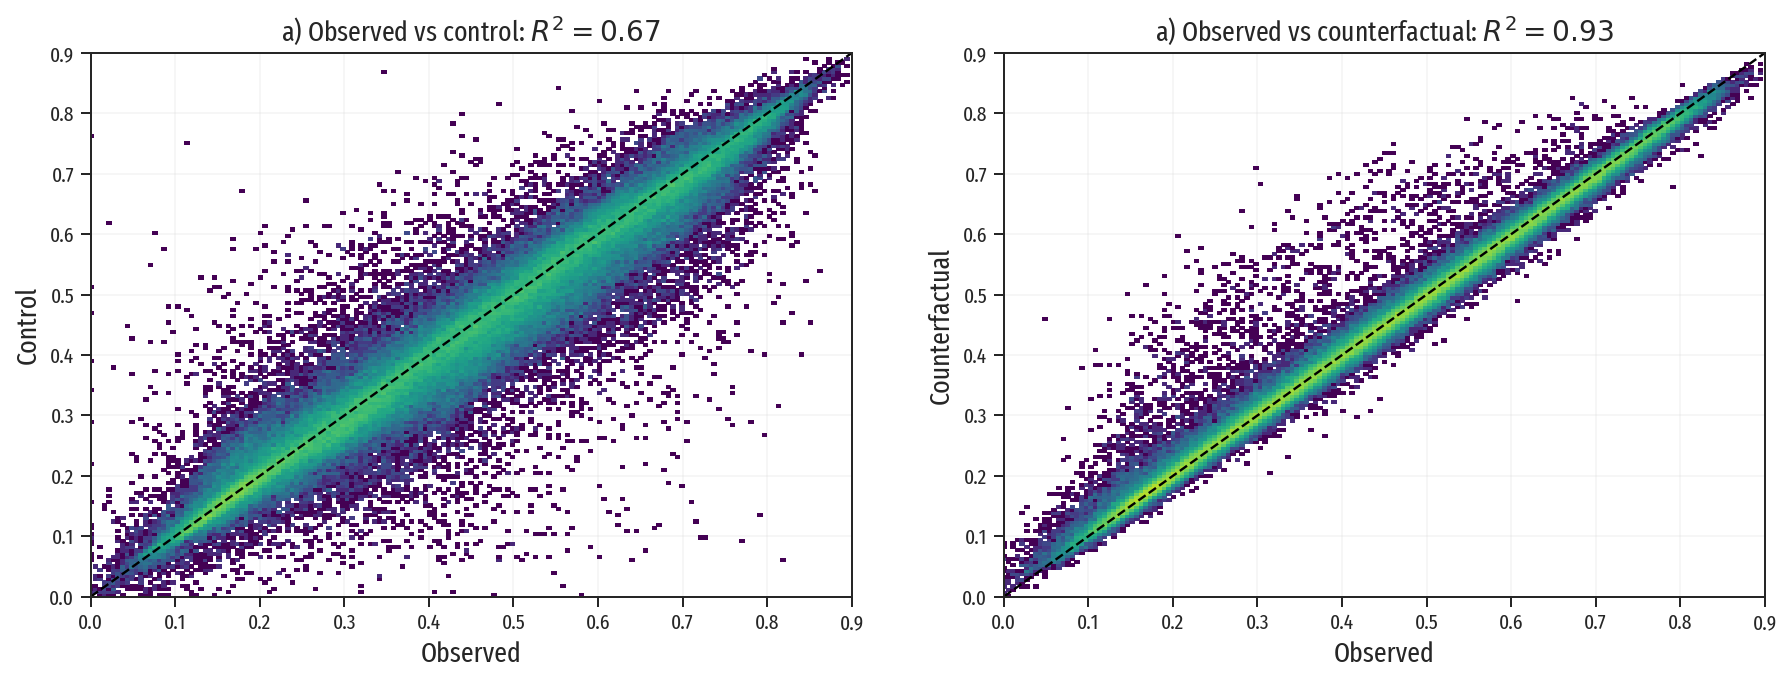

In [37]:
list_colors = ['red', 'blue', 'green', 'orange', 'gold', 'purple', 'black']
list_controls = flat_list = [item for sublist in list_co_pre for item in sublist]
list_counterfactuals = flat_list = [item for sublist in list_yhat_pre for item in sublist]
list_ys = flat_list = [item for sublist in list_ys_pre for item in sublist]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
im = ax[0].hist2d(list_ys, list_controls, bins=200,norm=mpl.colors.LogNorm(), cmap='viridis')#, vmin=0.00001, vmax=100000)
ax[1].hist2d(list_ys, list_counterfactuals, bins=200,norm=mpl.colors.LogNorm(), cmap='viridis')
ax[0].plot([0, 1], [0, 1], color='k', linestyle='--')
ax[1].plot([0, 1], [0, 1], color='k', linestyle='--')
ax[0].set(xlim=[0, .9], ylim=[0,.9], xlabel='Observed', ylabel='Control')
ax[1].set(xlim=[0, .9], ylim=[0,.9], xlabel='Observed', ylabel='Counterfactual')
ax[0].set_title('a) Observed vs control: $R^2={}$'.format(round(mean(list_r2s_control), 2)))
ax[1].set_title('a) Observed vs counterfactual: $R^2={}$'.format(round(mean(list_r2s_counterfactual), 2)))
ax[0].grid(True, alpha=.2)
ax[1].grid(True, alpha=.2)
for r in range(2):
    for item in [ax[r].title, ax[r].xaxis.label, ax[r].yaxis.label]:#,
#                 ax[r].get_xticklabels(), ax[r].get_yticklabels()]:
        item.set_fontsize(14)
#plt.suptitle('Error comparison on pre-wildfire periods')
plt.show()
fig.savefig(path_to_results+'Pretreatment_5yr_difference_control_counterfactual_observed_viridis_hist2d.png',
        dpi=400,
        format='png',
        pil_kwargs={'compression':'tiff_lzw'})

In [38]:
mean(list_r2s_control)

0.6725469244185124

In [39]:
mean(list_r2s_counterfactual)

0.9292586313382564

# Using 10 year pre-wildfires

In [40]:
df_Y_tr = read_csv('results/synthetic_control_objects/out_mc_ndvi_10y_pt/out_mc_ndvi_Y_tr.csv', index_col=0)
df_Y_co = read_csv('results/synthetic_control_objects/out_mc_ndvi_10y_pt/out_mc_ndvi_Y_co.csv', index_col=0)
df_Y_ct = read_csv('results/synthetic_control_objects/out_mc_ndvi_10y_pt/out_mc_ndvi_Y_ct.csv', index_col=0)

In [41]:
365 / 14

26.071428571428573

In [42]:
gdf[gdf.Fire_Name.isin(['HORSE', 'THURMAN', 'SHIRLEY'])]

Fire_ID Fire_Name  Year  StartMonth  StartDay Fire_Type  \
3    CA3271711662220060723     HORSE  2006           7        23        WF   
47   CA3411611700820051005   THURMAN  2005          10         5        WF   
128  CA3571711855520140613   SHIRLEY  2014           6        13        WF   
537  CA4190612128619960810     HORSE  1996           8        10        WF   

       Acres State    landcover  entropy_la  \
3    16719.0    CA  shrub_scrub    0.357648   
47    1076.0    CA  shrub_scrub    0.648800   
128   2794.0    CA  shrub_scrub    0.376491   
537   2602.0    CA  shrub_scrub    0.695818   

                                              geometry  
3    POLYGON ((-116.69248 32.72597, -116.69232 32.7...  
47   POLYGON ((-117.02185 34.10226, -117.02254 34.1...  
128  POLYGON ((-118.51053 35.68715, -118.51108 35.6...  
537  POLYGON ((-121.30015 41.88580, -121.30076 41.8...

In [43]:
path_to_results = 'results/'

0.01202341961473251
0.028969145557338236
Wildfire HORSE, predominated by shrub_scrub landcover, on year 2006, burned 16719.0 acres
Wildfire THURMAN, predominated by shrub_scrub landcover, on year 2005, burned 1076.0 acres
Wildfire SHIRLEY, predominated by shrub_scrub landcover, on year 2014, burned 2794.0 acres


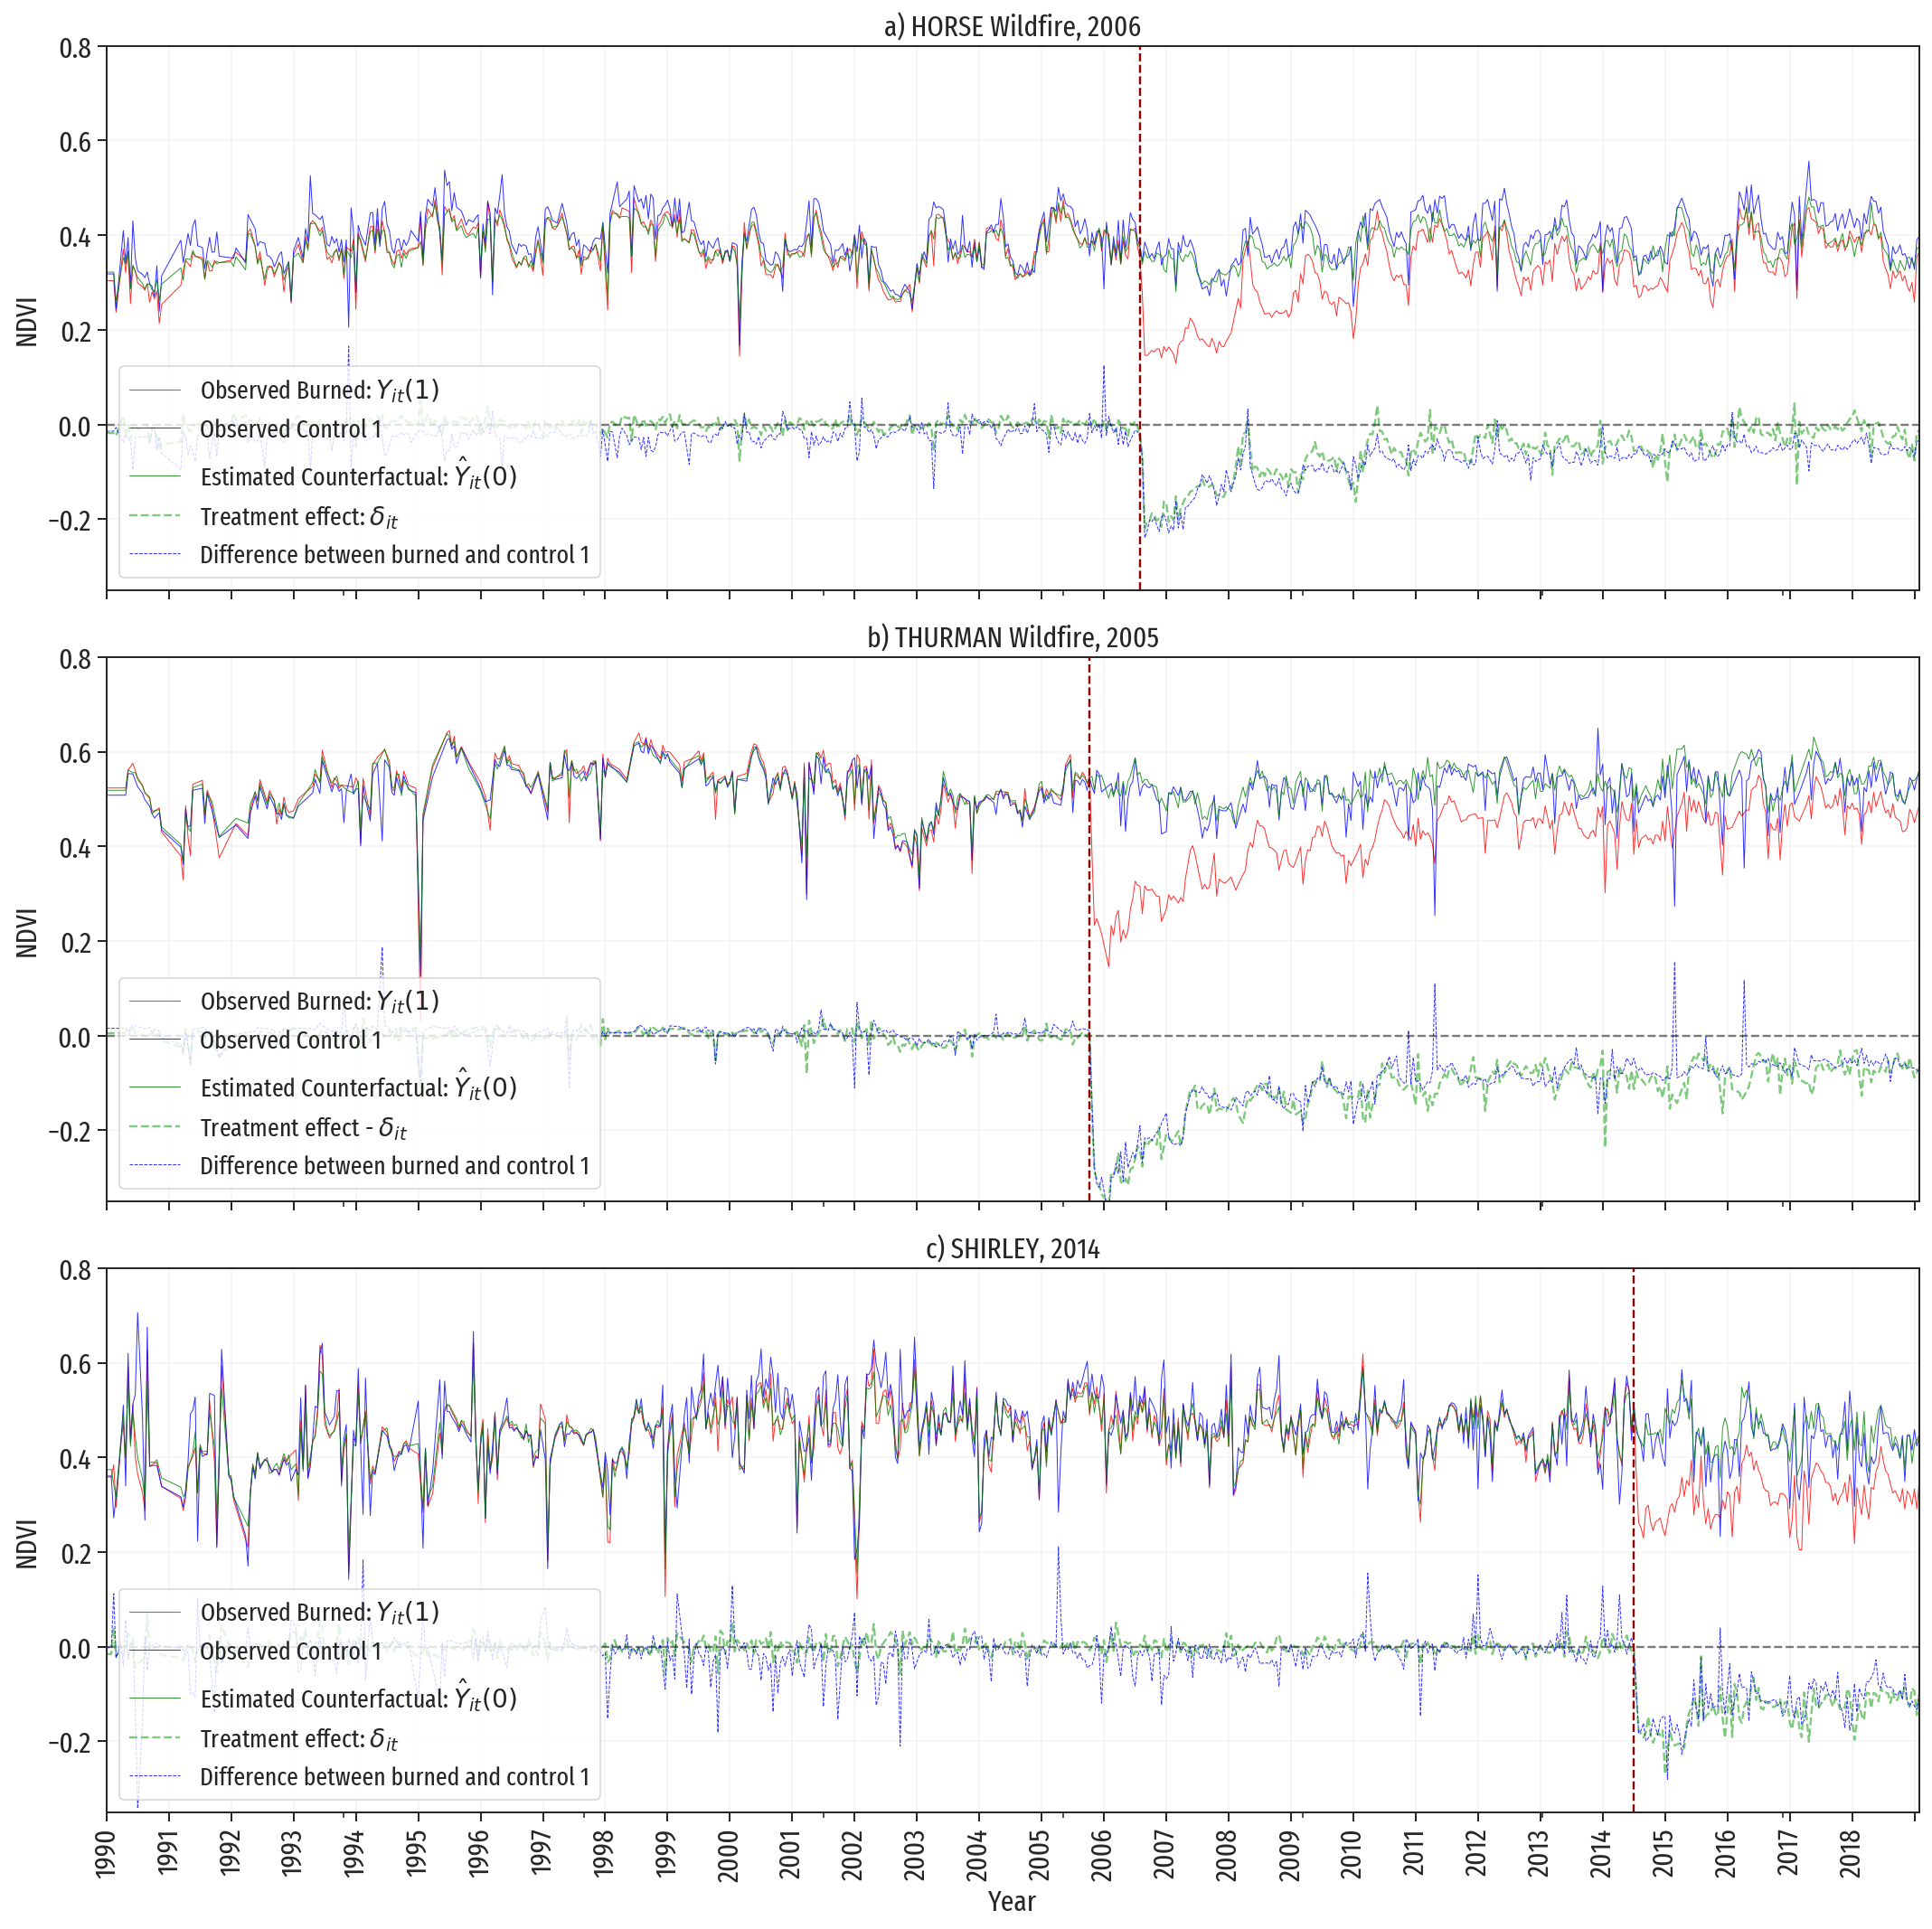

Wildfire SHIRLEY, predominated by shrub_scrub landcover, on year 2014, burned 2794.0 acres


In [44]:
id_ = 'CA3271711662220060723'
y_ = df_Y_tr['{}_A'.format(id_)].interpolate().fillna(method='ffill').fillna(method='bfill')
y_co_ = df_Y_co['{}_C1'.format(id_)].interpolate().fillna(method='ffill').fillna(method='bfill')
y_hat_ = df_Y_ct['{}_A'.format(id_)].interpolate().fillna(method='ffill').fillna(method='bfill')

print(mean_absolute_error(y_[:dict_treatments[id_]], y_hat_[:dict_treatments[id_]]))
print(mean_absolute_error(y_[:dict_treatments[id_]], y_co_[:dict_treatments[id_]]))
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(15, 15))

y_.plot(ax=ax[0], color='red', alpha=.8, linewidth=.5, label='Observed Burned: $Y_{it}(1)$')
y_co_.interpolate().plot(ax=ax[0], color='blue',alpha=.8, linewidth=.5, label='Observed Control 1')
y_hat_.interpolate().plot(ax=ax[0], color='green',alpha=.8, linewidth=.5, label='Estimated Counterfactual: $\hat{Y}_{it}(0)$')
title_ = gdf[gdf.Fire_ID == id_][['Fire_Name', 
                            'landcover', 
                            'Year',
                            'Acres']].values.tolist()[0]
print('Wildfire {}, predominated by {} landcover, on year {}, burned {} acres'.format(title_[0],
                                                                                             title_[1],
                                                                                             title_[2],
                                                                                             title_[3]))


(y_ - y_hat_).plot(ax=ax[0], label='Treatment effect: $\delta_{it}$', linestyle='--')
(y_ - y_co_).plot(ax=ax[0], color='blue',alpha=.8, linewidth=.5, linestyle='--', label='Difference between burned and control 1')
ax[0].axhline(y=0, xmin=0, xmax=757, color='k', linestyle='--', alpha=.5)
ax[0].legend(fontsize=14, loc='lower left')
ax[0].axvline(x=dict_treatments[id_], ymin=0, ymax=1, linestyle='--', color='darkred')
ax[0].set_xticks(ticks=list(range(1, 757, 26)))
ax[0].set_xticklabels(labels=[d.strftime('%Y') for d in date_range(start='1990-01-01', end='2019-12-01', freq='Y')],
           rotation=90)
ax[0].set_ylabel('NDVI')
ax[0].set_xlabel('Year')
ax[0].set_ylim([-.35, 0.8])
ax[0].set_xlim([1, 757])
ax[0].set_title('a) HORSE Wildfire, 2006')
ax[0].grid(True, alpha=.2)

id_ = 'CA3411611700820051005'
y_ = df_Y_tr['{}_A'.format(id_)].interpolate().fillna(method='ffill').fillna(method='bfill')
y_co_ = df_Y_co['{}_C1'.format(id_)].interpolate().fillna(method='ffill').fillna(method='bfill')
y_hat_ = df_Y_ct['{}_A'.format(id_)].interpolate().fillna(method='ffill').fillna(method='bfill')

y_.plot(ax=ax[1], color='red', alpha=.8, linewidth=.5, label='Observed Burned: $Y_{it}(1)$')
y_co_.interpolate().plot(ax=ax[1], color='blue',alpha=.8, linewidth=.5, label='Observed Control 1')
y_hat_.interpolate().plot(ax=ax[1], color='green',alpha=.8, linewidth=.5, label='Estimated Counterfactual: $\hat{Y}_{it}(0)$')
title_ = gdf[gdf.Fire_ID == id_][['Fire_Name', 
                            'landcover', 
                            'Year',
                            'Acres']].values.tolist()[0]

title_ = gdf[gdf.Fire_ID == id_][['Fire_Name', 
                            'landcover', 
                            'Year',
                            'Acres']].values.tolist()[0]
print('Wildfire {}, predominated by {} landcover, on year {}, burned {} acres'.format(title_[0],
                                                                                             title_[1],
                                                                                             title_[2],
                                                                                             title_[3]))
(y_ - y_hat_).plot(ax=ax[1], label='Treatment effect - $\delta_{it}$', linestyle='--')
(y_ - y_co_).plot(ax=ax[1], color='blue',alpha=.8, linewidth=.5, linestyle='--', label='Difference between burned and control 1')
ax[1].axhline(y=0, xmin=0, xmax=757, color='k', linestyle='--', alpha=.5)
ax[1].legend(fontsize=14, loc='lower left')
ax[1].axvline(x=dict_treatments[id_], ymin=0, ymax=1, linestyle='--', color='darkred')
ax[1].set_xticks(ticks=list(range(1, 757, 26)))
ax[1].set_xticklabels(labels=[d.strftime('%Y') for d in date_range(start='1990-01-01', end='2019-12-01', freq='Y')],
           rotation=90)
ax[1].set_ylabel('NDVI')
ax[1].set_xlabel('Year')
ax[1].set_ylim([-.35, 0.8])
ax[1].set_xlim([1, 757])
ax[1].set_title('b) THURMAN Wildfire, 2005')
ax[1].grid(True, alpha=.2)



id_ = 'CA3571711855520140613'
y_ = df_Y_tr['{}_A'.format(id_)].interpolate().fillna(method='ffill').fillna(method='bfill')
y_co_ = df_Y_co['{}_C1'.format(id_)].interpolate().fillna(method='ffill').fillna(method='bfill')
y_hat_ = df_Y_ct['{}_A'.format(id_)].interpolate().fillna(method='ffill').fillna(method='bfill')

y_.plot(ax=ax[2], color='red', alpha=.8, linewidth=.5, label='Observed Burned: $Y_{it}(1)$')
y_co_.interpolate().plot(ax=ax[2], color='blue',alpha=.8, linewidth=.5, label='Observed Control 1')
y_hat_.interpolate().plot(ax=ax[2], color='green',alpha=.8, linewidth=.5, label='Estimated Counterfactual: $\hat{Y}_{it}(0)$')
title_ = gdf[gdf.Fire_ID == id_][['Fire_Name', 
                            'landcover', 
                            'Year',
                            'Acres']].values.tolist()[0]
print('Wildfire {}, predominated by {} landcover, on year {}, burned {} acres'.format(title_[0],
                                                                                             title_[1],
                                                                                             title_[2],
                                                                                             title_[3]))


(y_ - y_hat_).plot(ax=ax[2], label='Treatment effect: $\delta_{it}$', linestyle='--')
(y_ - y_co_).plot(ax=ax[2], color='blue',alpha=.8, linewidth=.5, linestyle='--', label='Difference between burned and control 1')
ax[2].axhline(y=0, xmin=0, xmax=757, color='k', linestyle='--', alpha=.5)
ax[2].legend(fontsize=14, loc='lower left')
ax[2].axvline(x=dict_treatments[id_], ymin=0, ymax=1, linestyle='--', color='darkred')
ax[2].set_xticks(ticks=list(range(1, 757, 26)))
ax[2].set_xticklabels(labels=[d.strftime('%Y') for d in date_range(start='1990-01-01', end='2019-12-01', freq='Y')],
           rotation=90)
ax[2].set_ylabel('NDVI')
ax[2].set_xlabel('Year')
ax[2].set_ylim([-.35, 0.8])
ax[2].set_xlim([1, 757])
ax[2].set_title('c) SHIRLEY, 2014')
ax[2].grid(True, alpha=.2)

for _row in range(3):     
        for item in ([ax[_row].title, ax[_row].xaxis.label, ax[_row].yaxis.label] +
                     ax[_row].get_xticklabels() + ax[_row].get_yticklabels()):
            item.set_fontsize(16)
            
plt.tight_layout()
plt.show()
fig.savefig(path_to_results+'Sample_wildfire_effect_HORSE.png',
        dpi=400,
        format='png',
        pil_kwargs={'compression':'tiff_lzw'})
print('Wildfire {}, predominated by {} landcover, on year {}, burned {} acres'.format(title_[0],
                                                                                             title_[1],
                                                                                             title_[2],
                                                                                             title_[3]))

#### To plot any specific FIRE_ID change it here

In [45]:
id_ = 'CA3387911608820060707'

0.008612524593289386
0.02912288287238606


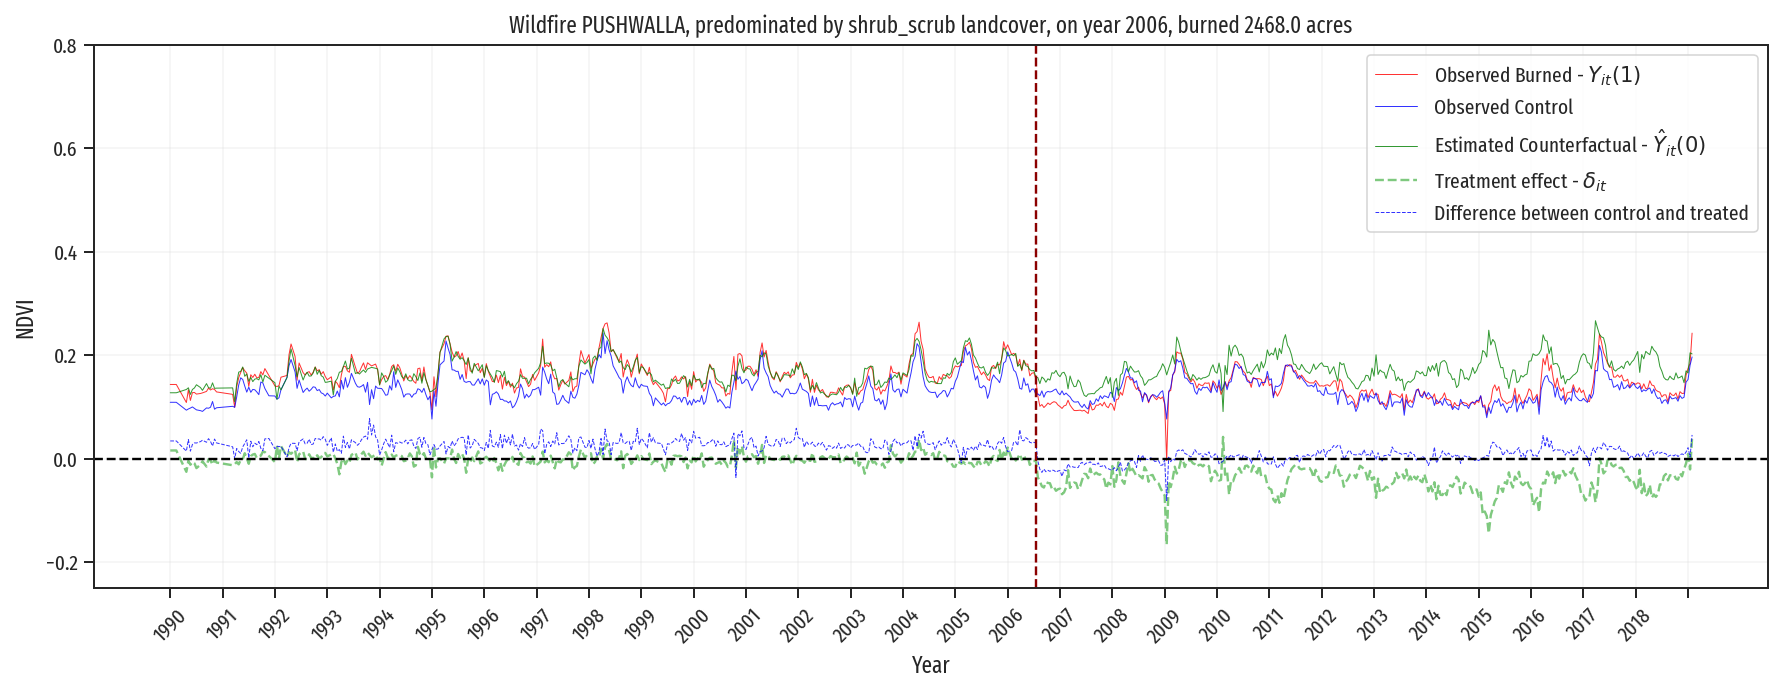

In [46]:
y_ = df_Y_tr['{}_A'.format(id_)].interpolate().fillna(method='ffill').fillna(method='bfill')
y_co_ = df_Y_co['{}_C1'.format(id_)].interpolate().fillna(method='ffill').fillna(method='bfill')
y_hat_ = df_Y_ct['{}_A'.format(id_)].interpolate().fillna(method='ffill').fillna(method='bfill')

print(mean_absolute_error(y_[:dict_treatments[id_]], y_hat_[:dict_treatments[id_]]))
print(mean_absolute_error(y_[:dict_treatments[id_]], y_co_[:dict_treatments[id_]]))
fig, ax = plt.subplots(figsize=(15, 5))

y_.plot(ax=ax, color='red', alpha=.8, linewidth=.5, label='Observed Burned - $Y_{it}(1)$')
y_co_.interpolate().plot(ax=ax, color='blue',alpha=.8, linewidth=.5, label='Observed Control')
y_hat_.interpolate().plot(ax=ax, color='green',alpha=.8, linewidth=.5, label='Estimated Counterfactual - $\hat{Y}_{it}(0)$')
title_ = gdf[gdf.Fire_ID == id_][['Fire_Name', 
                            'landcover', 
                            'Year',
                            'Acres']].values.tolist()[0]
plt.title('Wildfire {}, predominated by {} landcover, on year {}, burned {} acres'.format(title_[0],
                                                                                             title_[1],
                                                                                             title_[2],
                                                                                             title_[3]))
(y_ - y_hat_).plot(label='Treatment effect - $\delta_{it}$', linestyle='--')
(y_ - y_co_).plot(ax=ax, color='blue',alpha=.8, linewidth=.5, linestyle='--', label='Difference between control and treated')
plt.axhline(y=0, xmin=0, xmax=757, color='k', linestyle='--')
plt.legend()
plt.axvline(x=dict_treatments[id_], ymin=0, ymax=1, linestyle='--', color='darkred')
plt.xticks(ticks=list(range(1, 757, 26)), 
           labels=[d.strftime('%Y') for d in date_range(start='1990-01-01', end='2019-12-01', freq='Y')],
               rotation=45)
plt.ylabel('NDVI')
plt.xlabel('Year')
plt.ylim([-.25, 0.8])
#plt.xticks(list(range(len(date_range(start='1990-01-01', end='2019-12-01', freq='2W')))),
#           date_range(start='1990-01-01', end='2019-12-01', freq='Y'))
plt.grid(True, alpha=.2)
plt.show()

In [47]:
list_errors_yhat_pre = list()
list_errors_yco_pre = list()
list_ys_pre = list()
list_co_pre = list()
list_yhat_pre = list()
list_errors_yhat_post = list()
list_errors_yco_post = list()
list_errors_yhat_post_5 = list()
list_errors_yco_post_5 = list()
list_ids = list()
list_predominant_lc = list()
list_areas = list()
make_plots = False
list_times_treatment = list()
list_zonemaps = list()
list_entropies = list()
list_years = list()
list_strati_groups = list()
list_fire_intensities = list()
make_plots_2 = False
for id_ in df_Y_tr.columns.tolist():
    try:
        id_ = id_.split('_')[0]
        if make_plots:
            fig, ax = plt.subplots(figsize=(15, 5))

            df_Y_tr['{}_A'.format(id_)].interpolate().plot(ax=ax, color='red', alpha=.8, linewidth=.5, label='Observed Burned - $Y_{it}(1)$')
            df_Y_co['{}_C1'.format(id_)].interpolate().plot(ax=ax, color='blue',alpha=.8, linewidth=.5, label='Observed Control')
            df_Y_ct['{}_A'.format(id_)].interpolate().plot(ax=ax, color='green',alpha=.8, linewidth=.5, label='Estimated Counterfactual - $\hat{Y}_{it}(0)$')
        title_ = gdf[gdf.Fire_ID == id_][['Fire_Name', 
                                    'landcover', 
                                    'Year',
                                    'Acres', 'entropy_la']].values.tolist()[0]
        y_ = df_Y_tr['{}_A'.format(id_)].interpolate().fillna(0)
        y_co_ = df_Y_co['{}_C1'.format(id_)].interpolate().fillna(0)
        y_hat_ = df_Y_ct['{}_A'.format(id_)].interpolate().fillna(0)
        list_ys_pre.append(y_[:dict_treatments[id_]].fillna(0))
        list_co_pre.append(y_co_[:dict_treatments[id_]].fillna(0))
        list_yhat_pre.append(y_hat_[:dict_treatments[id_]].fillna(0))
        print(mean_absolute_error(y_[:dict_treatments[id_]], y_co_[:dict_treatments[id_]])/\
             mean_absolute_error(y_[:dict_treatments[id_]], y_hat_[:dict_treatments[id_]]))
        list_ids.append(id_)
        list_predominant_lc.append(title_[1])
        list_areas.append(title_[3])
        list_errors_yhat_pre.append(mean_absolute_error(y_[:dict_treatments[id_]], y_hat_[:dict_treatments[id_]]))
        list_errors_yco_pre.append(mean_absolute_error(y_[:dict_treatments[id_]], y_co_[:dict_treatments[id_]]))
        list_errors_yhat_post.append(mean_absolute_error(y_[dict_treatments[id_]:], y_hat_[dict_treatments[id_]:]))
        list_errors_yco_post.append(mean_absolute_error(y_[dict_treatments[id_]:], y_co_[dict_treatments[id_]:]))
        list_errors_yhat_post_5.append(mean_absolute_error(y_[dict_treatments[id_]:dict_treatments[id_]+26*5], y_hat_[dict_treatments[id_]:dict_treatments[id_]+26*5]))
        list_errors_yco_post_5.append(mean_absolute_error(y_[dict_treatments[id_]:dict_treatments[id_]+26*5], y_co_[dict_treatments[id_]:dict_treatments[id_]+26*5]))
        list_times_treatment.append(dict_treatments[id_])
        list_zonemaps.append(dict_zone_maps[id_])
        list_entropies.append(title_[4])
        list_years.append(title_[2])
        list_strati_groups.append(dict_wf_strati[id_])
        if make_plots_2:
            ((df_Y_tr['{}_A'.format(id_)].interpolate().rolling(window=6).mean() - \
             df_Y_ct['{}_A'.format(id_)].interpolate().rolling(window=6).mean()) \
             - (df_Y_tr['{}_A'.format(id_)].interpolate().rolling(window=6).mean() - \
                df_Y_co['{}_C1'.format(id_)].interpolate().rolling(window=6).mean())).plot(figsize=(15, 5))
            (df_Y_tr['{}_A'.format(id_)].interpolate().rolling(window=6).mean() - \
             df_Y_ct['{}_A'.format(id_)].interpolate().rolling(window=6).mean()).plot(color='r')
            (df_Y_tr['{}_A'.format(id_)].interpolate().rolling(window=6).mean() - \
                df_Y_co['{}_C1'.format(id_)].interpolate().rolling(window=6).mean()).plot(color='g')
            plt.vlines(x=dict_treatments[id_], ymin=-0.1, ymax=.1, linestyle='--', color='darkred')
            plt.title('Difference n.c. - s.c.')
            plt.show()
        if make_plots:
            print('+' * 60)
            print(id_)
            plt.title('Wildfire {}, predominated by {} landcover, on year {}, burned {} acres'.format(title_[0],
                                                                                                         title_[1],
                                                                                                         title_[2],
                                                                                                         title_[3]))
            (df_Y_tr['{}_A'.format(id_)].interpolate() - df_Y_ct['{}_A'.format(id_)].interpolate()).plot(label='Treatment effect - $\delta_{it}$', linestyle='--')
            (df_Y_tr['{}_A'.format(id_)].interpolate() - \
                df_Y_co['{}_C1'.format(id_)].interpolate()).plot(ax=ax, color='blue',alpha=.8, linewidth=.5, linestyle='--', label='Difference between control and treated')
            plt.axhline(y=0, xmin=0, xmax=757, color='k', linestyle='--')
            plt.legend()
            plt.axvline(x=dict_treatments[id_], ymin=0, ymax=1, linestyle='--', color='darkred')
            plt.xticks(ticks=list(range(1, 757, 26)), 
                       labels=[d.strftime('%Y') for d in date_range(start='1990-01-01', end='2019-12-01', freq='Y')],
                           rotation=45)
            plt.ylabel('NDVI')
            plt.xlabel('Year')
            #plt.xticks(list(range(len(date_range(start='1990-01-01', end='2019-12-01', freq='2W')))),
            #           date_range(start='1990-01-01', end='2019-12-01', freq='Y'))
            plt.grid(True, alpha=.2)
            plt.show()
    except:
        
            # plt.show()
        print('ID:', id_, 'NOT FOUND.')

2.96457763096245
1.3317030649358728
2.085742929237585
2.426499506906076
1.3508003865963831
2.486205499546227
1.5314936178066112
1.6193958427605424
2.4962268961282503
2.39207801630562
4.357681518993243
3.9221182068386735
3.3976590390593935
8.164890833908146
2.948974693965342
1.1871213586692089
1.1411309690244122
3.758680115232435
1.2811653038139987
1.8149225050073512
2.3843892798754656
3.9433106949661787
2.3578228495411526
1.5388112196758894
3.8111617893965923
4.506372190449571
0.9548315735504356
1.5443260945409827
1.1415358059061578
1.8515382982031425
1.4996996737412664
3.252939488548112
1.2127685662003267
1.2852675033060448
2.6719694612946188
1.7523839018286214
1.0055136013144492
2.2020869491054134
1.1395259684286636
3.749253678491041
1.1017246112425323
2.530032423998345
1.97003650702831
1.7785129243456543
1.3326316639981621
0.9142509323159246
4.416347245343535
1.7768108025297926
1.3949418050973899
1.2699016462970198
2.1731296899039916
1.8638764055059713
3.8549829765781167
2.243597157

In [48]:
df_list_errors = DataFrame([list_errors_yhat_pre, list_errors_yco_pre,
                            list_errors_yhat_post, list_errors_yco_post,
                            list_errors_yhat_post_5, list_errors_yco_post_5,
                            list_ids, list_predominant_lc, list_areas, list_times_treatment,
                            list_zonemaps, list_entropies, list_years, list_strati_groups, 
                            list_fire_intensities]).T

In [49]:
df_list_errors.shape

(216, 15)

In [50]:
dict_lc_types = {'shrub_scrub':'Shrub/scrub',
                 'grassland_herbaceous':'Grassland - Herbaceous',
                 'evergreen_forest': 'Evergreen Forest',
                 'woody_wetlands': 'Woody - Wetlands',
                 'emergent_herbaceous_wetland': 'Emergent Herbaceous Weltand',
                 'cultivated_crops':'Cultivated Crops',
                 'rock_sand_clay':'Rock/Sand/Clay',
                 'developed_medium_intensity':'Developed Medium Intensity',
                 'mixed_forest':'Mixed Forest',
                 'developed_open_space':'Developed Open'}

In [51]:
df_list_errors.columns = ['error_yhat_pre', 'error_yco_pre',
                          'error_yhat_post', 'error_yco_post',
                          'error_yhat_post_5', 'error_yco_post_5',
                          'ID', 'LC', 'Area (acres)', 'time_treatment', 
                          'zone_map', 'entropy_lc', 'year', 'strati_group',
                          'fire_intensity']

In [52]:
df_list_errors['Most predominant Land Cover'] = df_list_errors['LC'].apply(lambda x: dict_lc_types[x])
df_list_errors['error_ratio'] = df_list_errors[['error_yhat_pre', 'error_yco_pre']].apply(lambda x: x[0] / x[1], axis=1)
df_list_errors.error_yhat_post_5 = df_list_errors.error_yhat_post_5.astype(float)

In [53]:
df_list_errors.dtypes

error_yhat_pre                  object
error_yco_pre                   object
error_yhat_post                 object
error_yco_post                  object
error_yhat_post_5              float64
error_yco_post_5                object
ID                              object
LC                              object
Area (acres)                    object
time_treatment                  object
zone_map                        object
entropy_lc                      object
year                            object
strati_group                    object
fire_intensity                  object
Most predominant Land Cover     object
error_ratio                    float64
dtype: object

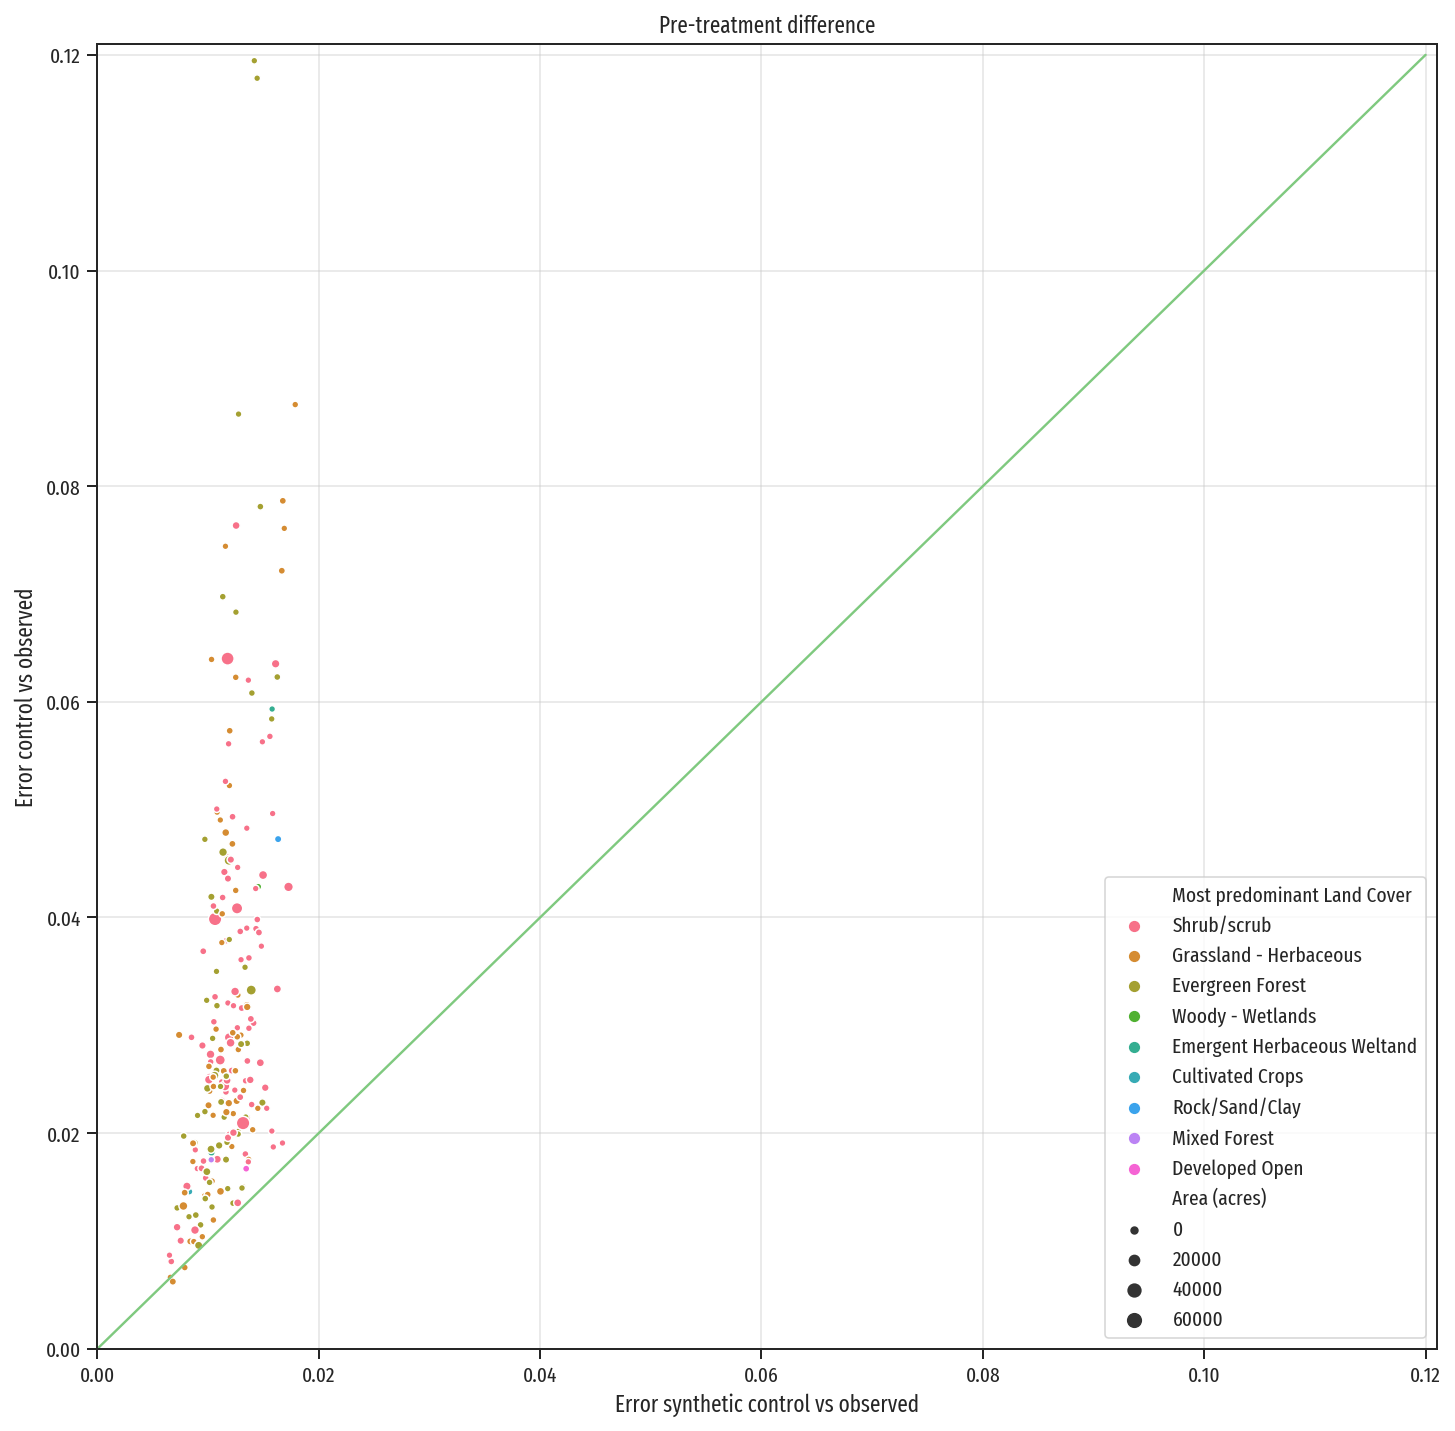

In [54]:
from pandas import to_numeric
path_to_results = 'results/'

df_list_errors["error_yhat_post_5"] = to_numeric(df_list_errors["error_yhat_post_5"])

fig = plt.figure(figsize=(12, 12))
sns.scatterplot('error_yhat_pre', 'error_yco_pre', 
                hue='Most predominant Land Cover',
                size='Area (acres)', data=df_list_errors)
plt.plot([0,.12], [0,.12])
plt.xlim([0,.121])
plt.ylim([0,.121])
plt.grid(True, alpha=.5)
plt.ylabel('Error control vs observed')
plt.xlabel('Error synthetic control vs observed')
plt.title('Pre-treatment difference')
plt.show()
fig.savefig(path_to_results+'Pretreatment_10yr_difference_counterfactual_observed.png',
        dpi=400,
        format='png',
        pil_kwargs={'compression':'tiff_lzw'})

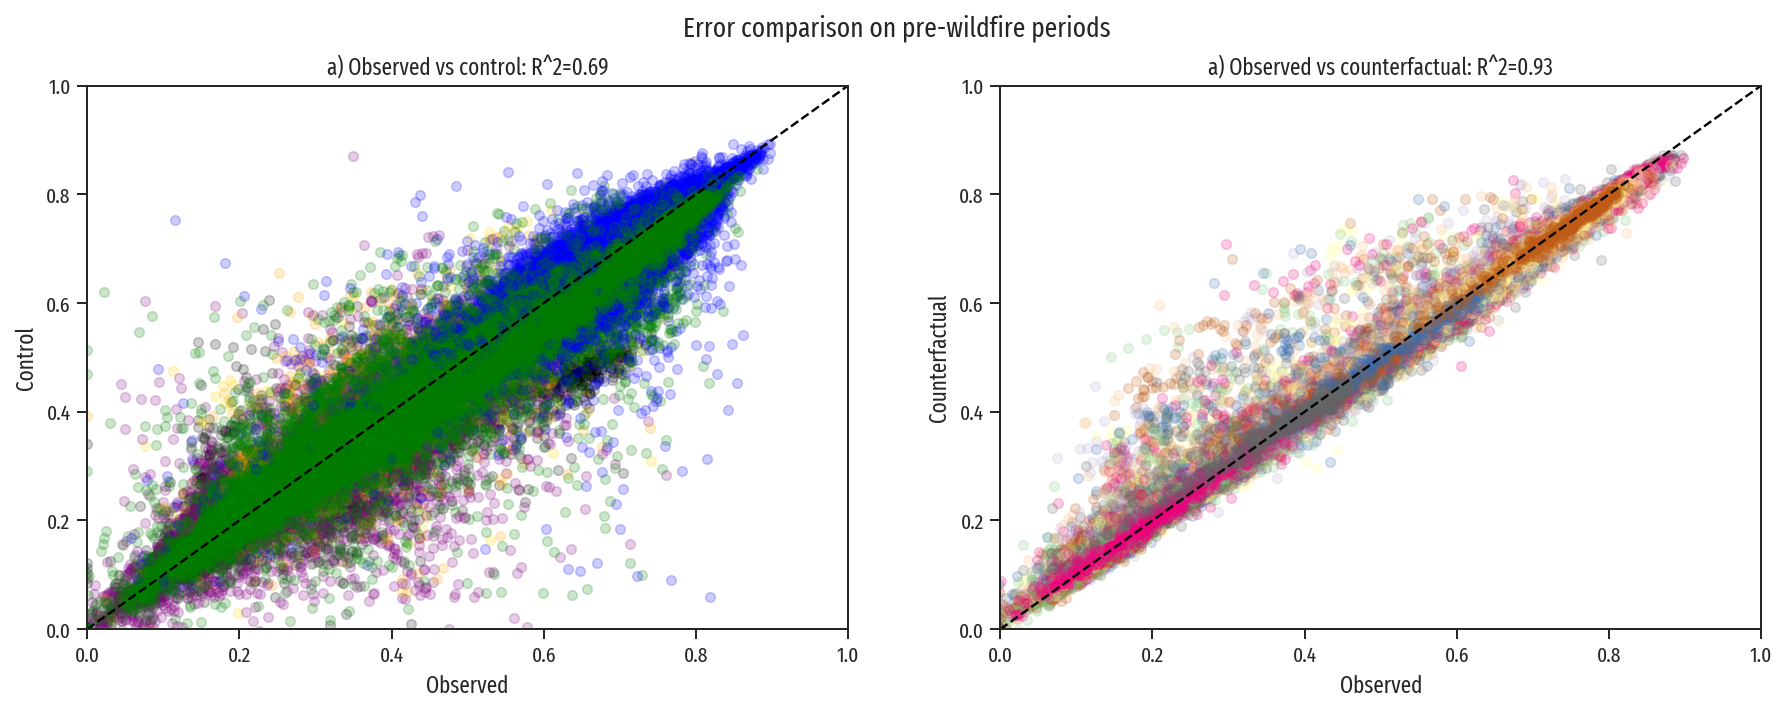

In [55]:
list_colors = ['red', 'blue', 'green', 'orange', 'gold', 'purple', 'black']
list_r2s_control = list()
list_r2s_counterfactual = list()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
for i in range(len(list_ys_pre)):
    ax[0].scatter(list_ys_pre[i], list_co_pre[i], alpha=.2, color=list_colors[list_zonemaps[i]])
    list_r2s_control.append(r2_score(list_ys_pre[i], list_co_pre[i]))
    ax[1].scatter(list_ys_pre[i], list_yhat_pre[i], alpha=.2, cmap=list_colors[list_zonemaps[i]])
    list_r2s_counterfactual.append(r2_score(list_ys_pre[i], list_yhat_pre[i]))
ax[0].plot([0, 1], [0, 1], color='k', linestyle='--')
ax[1].plot([0, 1], [0, 1], color='k', linestyle='--')
ax[0].set(xlim=[0, 1], ylim=[0,1], xlabel='Observed', ylabel='Control')
ax[1].set(xlim=[0, 1], ylim=[0,1], xlabel='Observed', ylabel='Counterfactual')
ax[0].set_title('a) Observed vs control: R^2={}'.format(round(mean(list_r2s_control), 2)))
ax[1].set_title('a) Observed vs counterfactual: R^2={}'.format(round(mean(list_r2s_counterfactual), 2)))
plt.suptitle('Error comparison on pre-wildfire periods')
plt.show()
fig.savefig(path_to_results+'Pretreatment_10yr_difference_control_counterfactual_observed.png',
        dpi=400,
        format='png',
        pil_kwargs={'compression':'tiff_lzw'})

In [56]:
len(list_yhat_pre)

216

In [57]:
slist_ys_pre = [st for row in list_ys_pre for st in row]
slist_co_pre = [st for row in list_co_pre for st in row]
slist_yhat_pre = [st for row in list_yhat_pre for st in row]

### Errors on pre-wildfire periods are ~5 times bigger

In [58]:
mean_squared_error(slist_co_pre, slist_ys_pre) / mean_squared_error(slist_yhat_pre, slist_ys_pre)

5.3767427647355905

In [59]:
list_greater_controls = list()
list_1 = list()
list_2 = list()
for i in range(len(list_co_pre)):
    _1 = mean_squared_error(list_co_pre[i], list_ys_pre[i])
    _2 = mean_squared_error(list_yhat_pre[i], list_ys_pre[i])
    list_1.append(_1)
    list_2.append(_2)
    if _1 < _2:
        list_greater_controls.append(i)

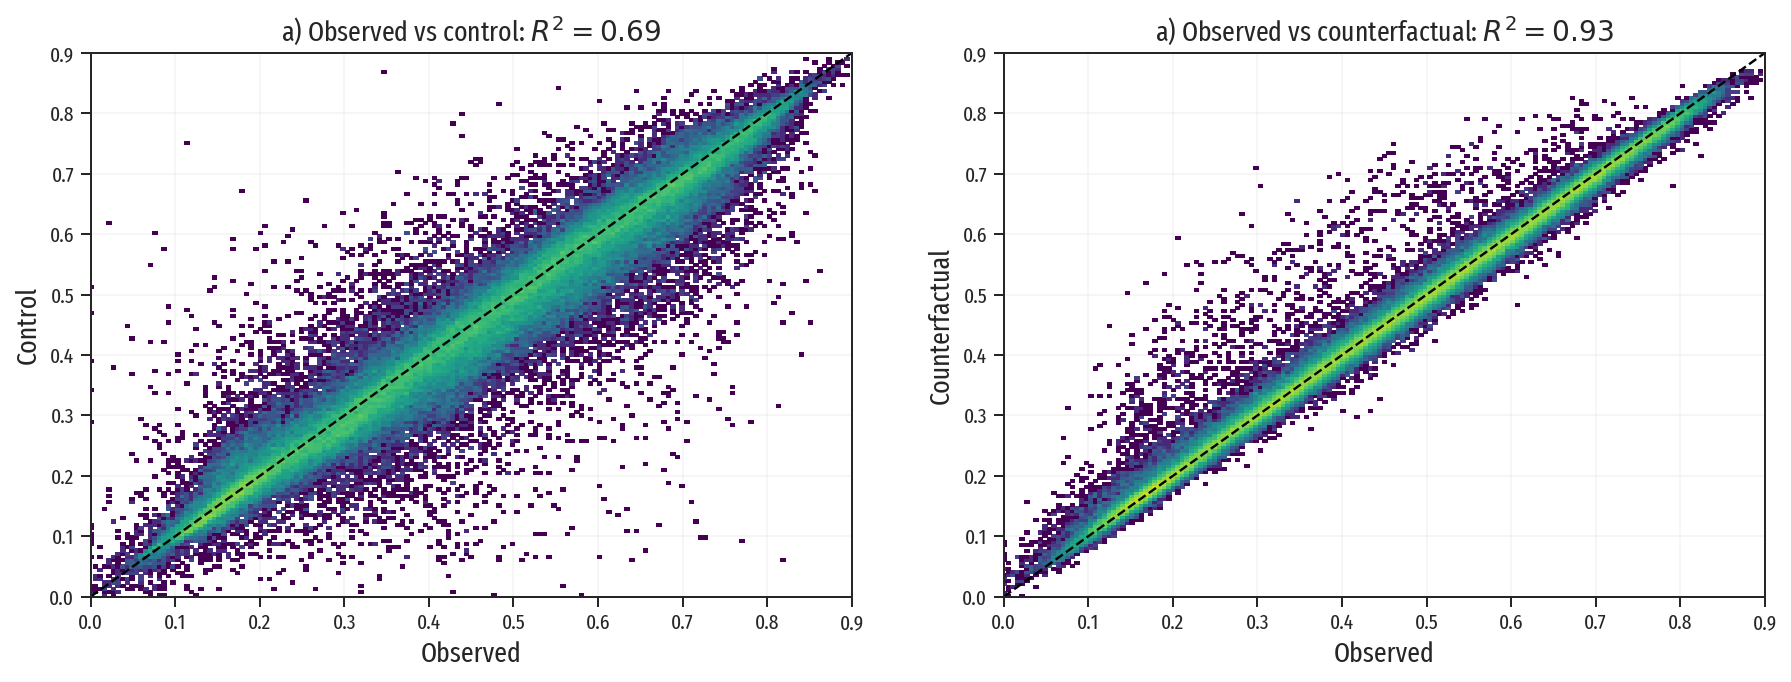

In [60]:

list_colors = ['red', 'blue', 'green', 'orange', 'gold', 'purple', 'black']
#list_r2s_control = list()
#list_r2s_counterfactual = list()
list_controls = flat_list = [item for sublist in list_co_pre for item in sublist]
list_counterfactuals = flat_list = [item for sublist in list_yhat_pre for item in sublist]
list_ys = flat_list = [item for sublist in list_ys_pre for item in sublist]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
im = ax[0].hist2d(list_ys, list_controls, bins=200,norm=mpl.colors.LogNorm(), cmap='viridis')#, vmin=0.00001, vmax=100000)
ax[1].hist2d(list_ys, list_counterfactuals, bins=200,norm=mpl.colors.LogNorm(), cmap='viridis')
    #ax[0].scatter(list_ys_pre[i], list_co_pre[i], alpha=.2, color=list_colors[list_zonemaps[i]])
    #list_r2s_control.append(r2_score(list_ys_pre[i], list_co_pre[i]))
    #ax[1].scatter(list_ys_pre[i], list_yhat_pre[i], alpha=.2, cmap=list_colors[list_zonemaps[i]])
    #list_r2s_counterfactual.append(r2_score(list_ys_pre[i], list_yhat_pre[i]))
#plt.colorbar(im)
ax[0].plot([0, 1], [0, 1], color='k', linestyle='--')
ax[1].plot([0, 1], [0, 1], color='k', linestyle='--')
ax[0].set(xlim=[0, .9], ylim=[0,.9], xlabel='Observed', ylabel='Control')
ax[1].set(xlim=[0, .9], ylim=[0,.9], xlabel='Observed', ylabel='Counterfactual')
ax[0].set_title('a) Observed vs control: $R^2={}$'.format(round(mean(list_r2s_control), 2)))
ax[1].set_title('a) Observed vs counterfactual: $R^2={}$'.format(round(mean(list_r2s_counterfactual), 2)))
ax[0].grid(True, alpha=.2)
ax[1].grid(True, alpha=.2)
for r in range(2):
    for item in [ax[r].title, ax[r].xaxis.label, ax[r].yaxis.label]:#,
#                 ax[r].get_xticklabels(), ax[r].get_yticklabels()]:
        item.set_fontsize(14)
#plt.suptitle('Error comparison on pre-wildfire periods')
plt.show()
fig.savefig(path_to_results+'Pretreatment_10yr_difference_control_counterfactual_observed_viridis_hist2d.png',
        dpi=400,
        format='png',
        pil_kwargs={'compression':'tiff_lzw'})

In [61]:
from numpy import mean

In [62]:
mean(list_r2s_control)

0.6878300658975072

In [63]:
mean(list_r2s_counterfactual)

0.9347359306916364